In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import math
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import itertools
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from xgboost import XGBClassifier
import tensorflow as tf
from sklearn.feature_selection import SelectKBest, f_classif
import joblib
import os

In [2]:
%load_ext autoreload
%autoreload 2

# todo (order or priority)
# figure out cholesterol regression
# decide on a cholesterol replacement method to use, redo ANOVA with it in place
# set up exporting and loading in tensorflow model to streamlit app
# allow streamlit to use any model
# make streamlit app look nicer

[Link To Data](https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction)

In [3]:
# load in data
df = pd.read_csv("heart_failure_data.csv")
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


# Exploratory Data Analysis (EDA)

### EDA Plan: What questions do we want to ask of the data?
1. Tabular descriptors to get a basic sense of the types of features in the dataset
2. How many positive and negative examples are there of the target variable?
3. How are continuous variables distributed (in particular, are they normally distributed)?
4. How do continuous variables change in conjunction with the target variable?
5. How many examples are there of each categorical variable?
6. How does each categorical variable change in conjunction with the target variable?

## EDA Step 1: Tabular Descriptors

In [4]:
df.columns

Index(['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS',
       'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope',
       'HeartDisease'],
      dtype='object')

### Attribute information:
1. Age: age of the patient [years]
2. Sex: sex of the patient [M: Male, F: Female]
3. ChestPainType: chest pain type [TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic]
4. RestingBP: resting blood pressure [mm Hg]
5. Cholesterol: serum cholesterol [mm/dl]
6. FastingBS: fasting blood sugar [1: if FastingBS > 120 mg/dl, 0: otherwise]
7. RestingECG: resting electrocardiogram results [Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria]
8. MaxHR: maximum heart rate achieved [Numeric value between 60 and 202]
9. ExerciseAngina: exercise-induced angina [Y: Yes, N: No]
10. Oldpeak: oldpeak = ST [Numeric value measured in depression]
11. ST_Slope: the slope of the peak exercise ST segment [Up: upsloping, Flat: flat, Down: downsloping]
12. HeartDisease: output class [1: heart disease, 0: Normal]

In [5]:
# Summary statistics for numerical features
numerical_features = df.select_dtypes(include=[np.number])
numerical_features = numerical_features.drop(["HeartDisease", "FastingBS"], axis=1)
numerical_features.describe()

,Age,RestingBP,Cholesterol,MaxHR,Oldpeak
count,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,136.809368,0.887364
std,9.432617,18.514154,109.384145,25.460334,1.066570
min,28.000000,0.000000,0.000000,60.000000,-2.600000
25%,47.000000,120.000000,173.250000,120.000000,0.000000
50%,54.000000,130.000000,223.000000,138.000000,0.600000
75%,60.000000,140.000000,267.000000,156.000000,1.500000
max,77.000000,200.000000,603.000000,202.000000,6.200000


In [6]:
# Summary statistics for categorical features
categorical_features = df.select_dtypes(include=[object])
categorical_features.describe()

,Sex,ChestPainType,RestingECG,ExerciseAngina,ST_Slope
count,918,918,918,918,918
unique,2,4,3,2,3
top,M,ASY,Normal,N,Flat
freq,725,496,552,547,460


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [8]:
# Check for null values in the dataset
df.isnull().sum()  # there are none, great [although later I find that cholesterol has null values set to 0]

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

## EDA step 2: visualizing the dataset

### How many positive and negative examples are there of the target variable?

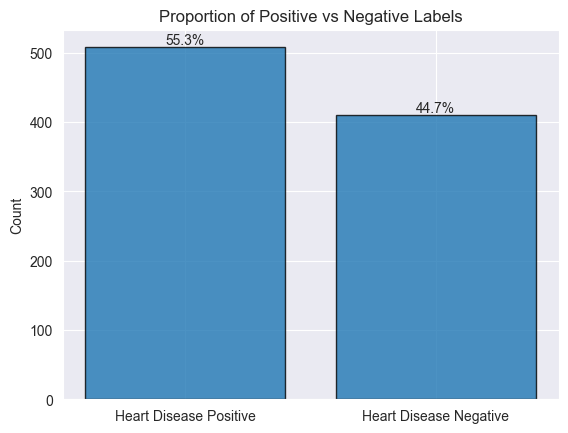

In [9]:
fig, ax = plt.subplots(1, 1)
bar_data = df["HeartDisease"].value_counts()
ax.bar([0, 1], bar_data, edgecolor="black", alpha=0.8)

ax.set_xticks([0, 1])
ax.set_xticklabels(["Heart Disease Positive", "Heart Disease Negative"])

for i, count in enumerate(bar_data):
    percentage = count / bar_data.sum() * 100
    ax.text(i, count, f"{percentage:.1f}%", ha="center", va="bottom")
ax.set_ylabel("Count")
ax.set_title("Proportion of Positive vs Negative Labels")
plt.show()

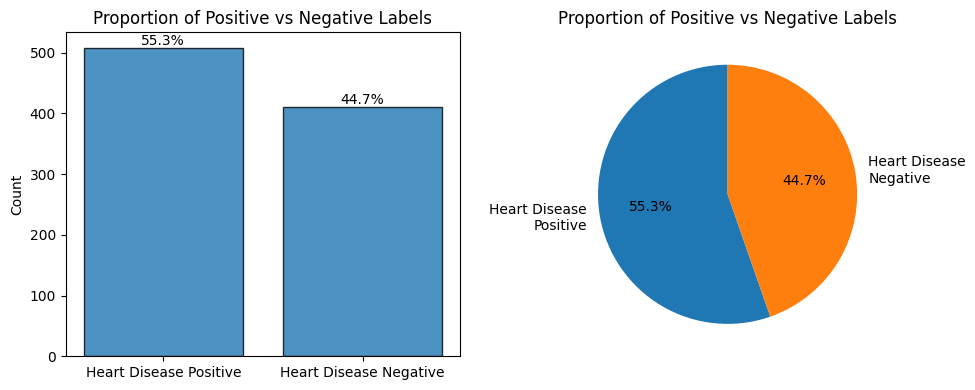

In [70]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Bar chart
ax_bar = axes[0]
bar_data = df["HeartDisease"].value_counts()
ax_bar.bar([0, 1], bar_data, edgecolor="black", alpha=0.8)
ax_bar.set_xticks([0, 1])
ax_bar.set_xticklabels(["Heart Disease Positive", "Heart Disease Negative"])
for i, count in enumerate(bar_data):
    percentage = count / bar_data.sum() * 100
    ax_bar.text(i, count, f"{percentage:.1f}%", ha="center", va="bottom")
ax_bar.set_ylabel("Count")
ax_bar.set_title("Proportion of Positive vs Negative Labels")

# Pie chart
ax_pie = axes[1]
labels = ["Heart Disease\nPositive", "Heart Disease\nNegative"]
sizes = bar_data.values
ax_pie.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
ax_pie.set_title("Proportion of Positive vs Negative Labels")

plt.tight_layout()
plt.savefig(os.path.join("visualizations", "label_quantity.png"), dpi=300)
plt.show()

The dataset is pretty balanced, I shouldn't need to worry about any sort of rebalancing or Synthetic Minority Over-sampling

### How are continuous variables distributed (in particular, are they normally distributed)?

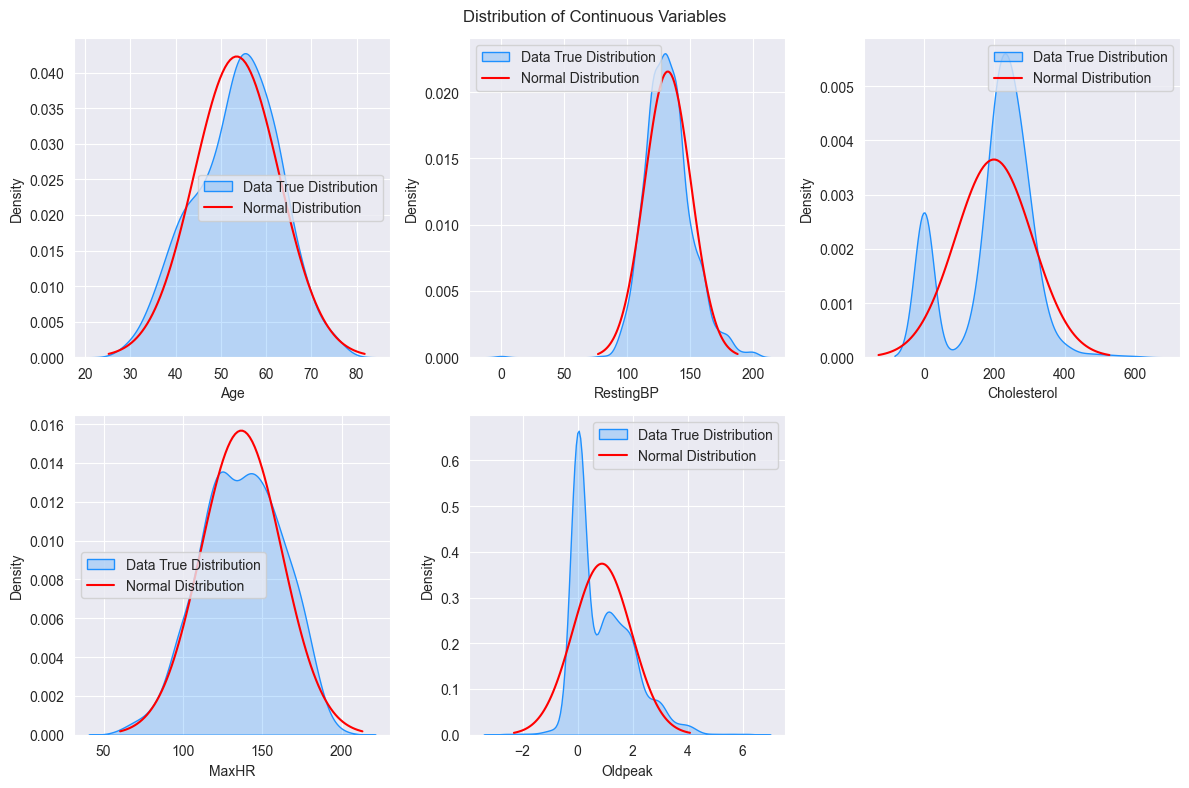

In [11]:
continuous_feature_names = numerical_features.columns.tolist()

num_features = len(continuous_feature_names)
num_rows = 2  # Number of rows in the subplot grid
num_cols = 3  # Number of columns in the subplot grid

fig, axes = plt.subplots(num_rows, num_cols, figsize=(4 * num_cols, 4 * num_rows))

for i, cont_feature in enumerate(numerical_features):
    row = i // num_cols  # Calculate the row index for the subplot
    col = i % num_cols  # Calculate the column index for the subplot

    ax_kde = axes[row, col]

    # Plot KDE for the feature
    sns.kdeplot(df[cont_feature], ax=ax_kde, fill=True, color="dodgerblue", label="Data True Distribution")

    # Add normal distribution curve
    mean = df[cont_feature].mean()
    sd = df[cont_feature].std()
    x = np.linspace(mean - 3 * sd, mean + 3 * sd, 100)
    y = stats.norm.pdf(x, mean, sd)
    ax_kde.plot(x, y, color="red", label="Normal Distribution")
    ax_kde.legend()  # Add legend to the current subplot


# Remove empty subplots
if num_features < num_rows * num_cols:
    for i in range(num_features, num_rows * num_cols):
        fig.delaxes(axes.flatten()[i])

plt.suptitle("Distribution of Continuous Variables")
plt.tight_layout()
plt.savefig(os.path.join("visualizations", "continuous_distribution.png"), dpi=300)
plt.show()

In [12]:
df["Cholesterol"].value_counts()

Cholesterol
0      172
254     11
223     10
220     10
230      9
      ... 
392      1
316      1
153      1
466      1
131      1
Name: count, Length: 222, dtype: int64

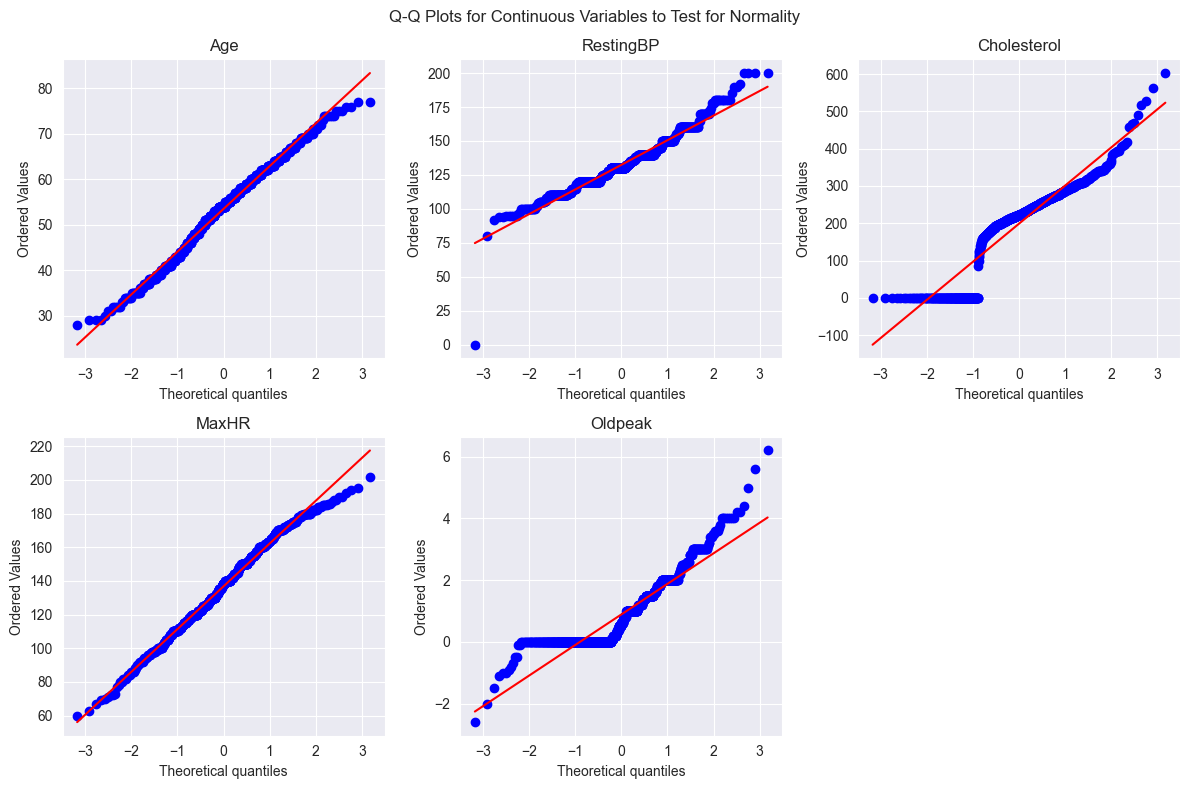

In [13]:
num_features = len(continuous_feature_names)
num_rows = 2  # Number of rows in the subplot grid
num_cols = 3  # Number of columns in the subplot grid

fig, axes = plt.subplots(num_rows, num_cols, figsize=(4 * num_cols, 4 * num_rows))

for i, cont_feature in enumerate(continuous_feature_names):
    row = i // num_cols  # Calculate the row index for the subplot
    col = i % num_cols  # Calculate the column index for the subplot

    ax_qq = axes[row, col]

    # Generate QQ-plot
    stats.probplot(df[cont_feature], plot=ax_qq)
    ax_qq.set_title(cont_feature)  # Set the title as the feature name

# Remove empty subplots
if num_features < num_rows * num_cols:
    for i in range(num_features, num_rows * num_cols):
        fig.delaxes(axes.flatten()[i])

plt.suptitle("Q-Q Plots for Continuous Variables to Test for Normality")
plt.tight_layout()
plt.savefig(os.path.join("visualizations", "qq_plots.png"), dpi=300)
plt.show()

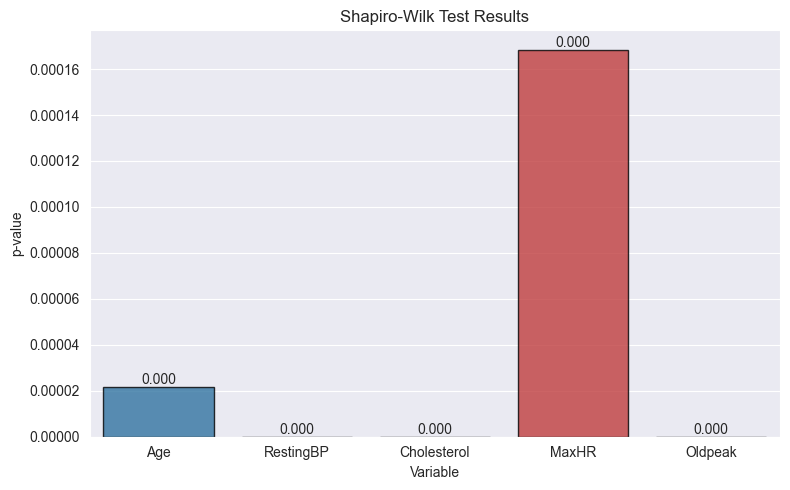

,Variable,Test Statistic,p-value
0,Age,0.991014,2.170773e-05
1,RestingBP,0.958043,1.495117e-15
2,Cholesterol,0.870593,6.972956e-27
3,MaxHR,0.992672,1.683979e-04
4,Oldpeak,0.859877,8.269673e-28


In [14]:
# Create an empty DataFrame to store the results
shapiro_wilk_results = pd.DataFrame(columns=["Variable", "Test Statistic", "p-value"])

# Iterate over the features and perform the Shapiro-Wilk test
for feature in continuous_feature_names:
    # Extract the data for the current feature
    data = df[feature]
    # Perform Shapiro-Wilk test
    statistic, p_value = stats.shapiro(data)
    # Create a temporary DataFrame for the current result
    temp_df = pd.DataFrame({"Variable": [feature], "Test Statistic": [statistic], "p-value": [p_value]})

    # Concatenate the temporary DataFrame with the results DataFrame
    shapiro_wilk_results = pd.concat([shapiro_wilk_results, temp_df], ignore_index=True)

# Plot the results
fig, ax = plt.subplots(figsize=(8, 5))
# Create the bar plot using seaborn
barplot = sns.barplot(data=shapiro_wilk_results, x="Variable", y="p-value", edgecolor="black", alpha=0.8)

# Set labels and title
ax.set_xlabel("Variable")
ax.set_ylabel("p-value")
ax.set_title("Shapiro-Wilk Test Results")

# Add the p-value labels above each bar
for p in barplot.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2, height, f"{height:.3f}", ha="center", va="bottom")

# Display the plot
plt.tight_layout()
plt.show()

# Display the results in a dataframe
display(shapiro_wilk_results)

Takeaways:
1. It looks like cholesterol was set to 0 as a null value, because people can't actually have 0 cholesterol and there are 172 entries of 0 cholesterol
2. Age, RestingBP, MaxHR look pretty close to normally distributed
3. Cholesterol's non-zero distribution looks pretty close to Gaussian
3. Oldpeak doesn't look Gaussian
4. Despite how the distributions appear, none of them are normally distributed, as determined by shapiro-wilk test and Q-Q plot looking imperfect

## How do continuous variables change in conjunction with the target variable?

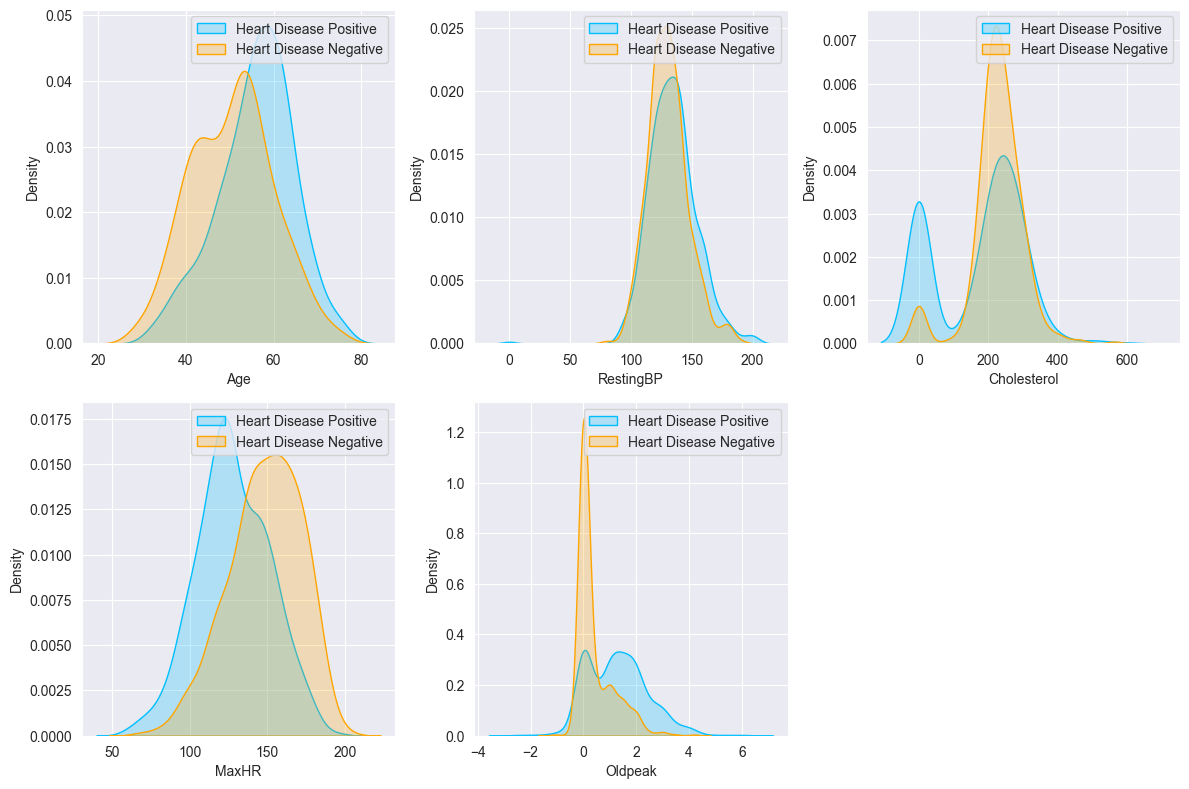

In [15]:
positive = df[df["HeartDisease"] == 1]  # Subset of data for heart failure cases
negative = df[df["HeartDisease"] == 0]  # Subset of data for non-heart failure cases

num_features = len(continuous_feature_names)
num_rows = 2  # Number of rows in the subplot grid
num_cols = 3  # Number of columns in the subplot grid

fig, axes = plt.subplots(num_rows, num_cols, figsize=(4 * num_cols, 4 * num_rows))

for i, cont_feature in enumerate(numerical_features):
    row = i // num_cols  # Calculate the row index for the subplot
    col = i % num_cols  # Calculate the column index for the subplot

    ax_kde = axes[row, col]

    # Plot KDE for heart failure positive cases
    sns.kdeplot(positive[cont_feature], ax=ax_kde, fill=True, color="deepskyblue", label="Heart Disease Positive")

    # Plot KDE for heart failure negative cases
    sns.kdeplot(negative[cont_feature], ax=ax_kde, fill=True, color="orange", label="Heart Disease Negative")

    ax_kde.legend()

# Remove empty subplots
if num_features < num_rows * num_cols:
    for i in range(num_features, num_rows * num_cols):
        fig.delaxes(axes.flatten()[i])

plt.tight_layout()
plt.savefig(os.path.join("visualizations", "continuous_target.png"), dpi=300)
plt.show()

compare mean of each feature for positive vs negative

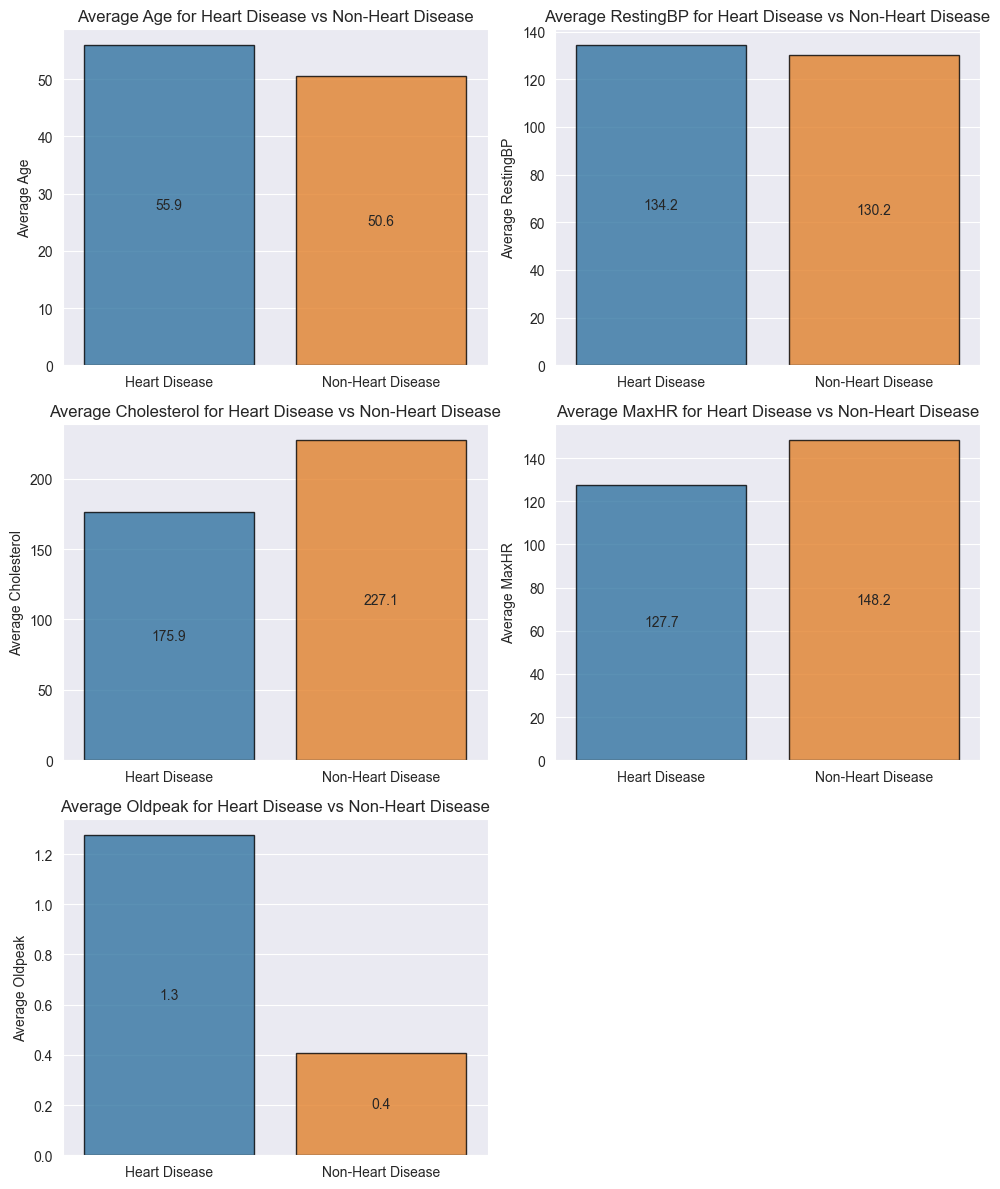

In [16]:
fig, axes = plt.subplots(3, 2, figsize=(10, 12))

# Looping through each feature
for i, feature in enumerate(continuous_feature_names):
    row = i // 2  # Calculate the row index for the subplot
    col = i % 2  # Calculate the column index for the subplot

    avg_heart_failure = positive[feature].mean()
    avg_non_heart_failure = negative[feature].mean()

    # Creating the bar chart for the current feature
    ax = axes[row, col]
    # ax.bar(["Heart Disease", "Non-Heart Disease"], [avg_heart_failure, avg_non_heart_failure])
    sns.barplot(x=["Heart Disease", "Non-Heart Disease"], y=[avg_heart_failure, avg_non_heart_failure], ax=ax, edgecolor="black", alpha=0.8)
    ax.set_ylabel("Average " + feature)
    ax.set_title("Average " + feature + " for Heart Disease vs Non-Heart Disease")

    # Adding annotations to the bars
    ax.annotate(f"{avg_heart_failure:.1f}", xy=(0, avg_heart_failure/2), ha="center", va="center")
    ax.annotate(f"{avg_non_heart_failure:.1f}", xy=(1, avg_non_heart_failure/2), ha="center", va="center")

# Remove the empty subplot in the bottom right corner
fig.delaxes(axes[2, 1])

# Adjusting the layout and spacing
plt.tight_layout()

# Displaying the chart
plt.show()


Takeaways:
1. Age, Oldpeak, MaxHR look very important because they change meaningfully in positive vs negative cases
2. RestingBP seems close to the same for positive and negative
3. It seems like many more people with heart disease have cholesterol labelled as 0

### How many examples are there of each categorical variable?

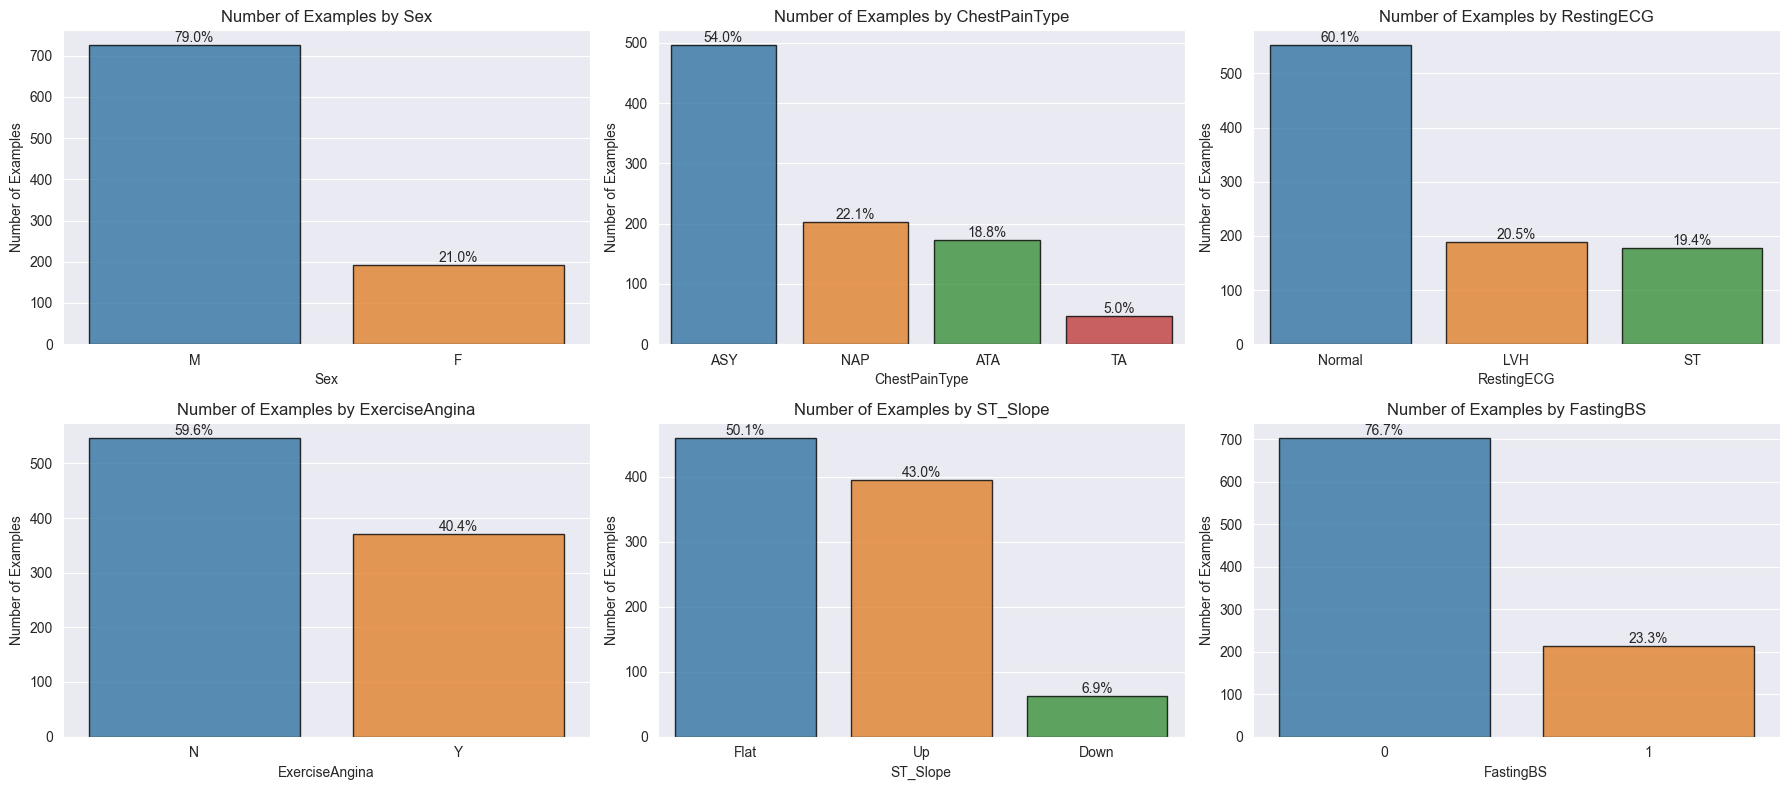

In [17]:
categorical_feature_names = categorical_features.columns.to_list() + ["FastingBS"]

num_features = len(categorical_feature_names)
num_rows = 2
num_cols = math.ceil(num_features / num_rows)


fig, axes = plt.subplots(num_rows, num_cols, figsize=(6 * num_cols, 4 * num_rows))

for i, cat_feature in enumerate(categorical_feature_names):
    row = i // num_cols  # Calculate the row index for the subplot
    col = i % num_cols  # Calculate the column index for the subplot

    # Calculate number of examples and percentages for each category
    category_counts = df[cat_feature].value_counts()
    category_percentages = category_counts / len(df) * 100

    ax = axes[row, col]

    # Create bar plot for number of examples
    sns.barplot(x=category_counts.index, y=category_counts.values, ax=ax, edgecolor="black", alpha=0.8)

    ax.set_xlabel(cat_feature)
    ax.set_ylabel("Number of Examples")
    ax.set_title(f"Number of Examples by {cat_feature}")

    # Add percentage annotations
    for j, count in enumerate(category_counts):
        percentage = category_percentages[j]
        ax.text(j, count, f'{percentage:.1f}%', ha='center', va='bottom')

# Remove empty subplots
if num_features < num_rows * num_cols:
    for i in range(num_features, num_rows * num_cols):
        fig.delaxes(axes.flatten()[i])

plt.tight_layout()
plt.savefig(os.path.join("visualizations", "categorical_var_examples.png"), dpi=300)
plt.show()

### How does each categorical variable change in conjunction with the target variable?

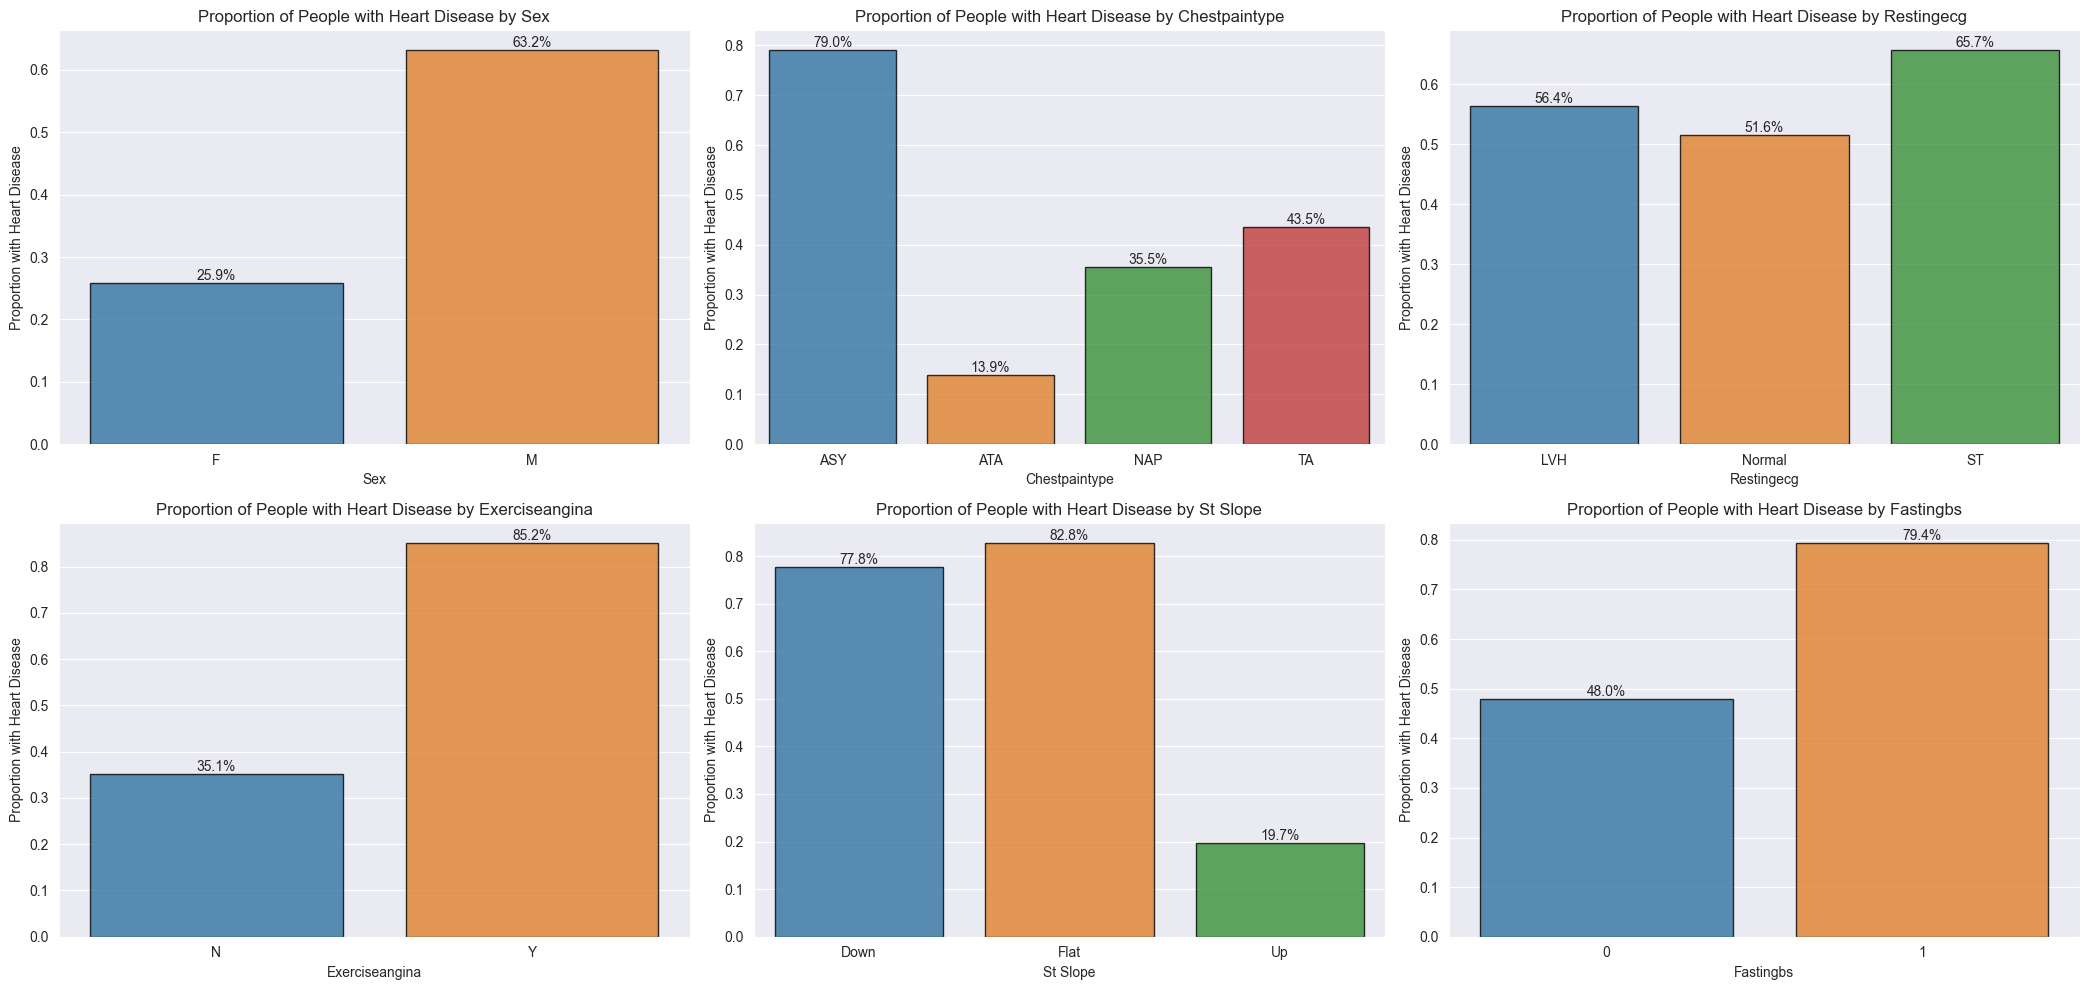

In [18]:
num_features = len(categorical_feature_names)
num_rows = 2
num_cols = math.ceil(num_features / num_rows)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(7 * num_cols, 5 * num_rows))

for i, cat_feature in enumerate(categorical_feature_names):
    row = i // num_cols  # Calculate the row index for the subplot
    col = i % num_cols  # Calculate the column index for the subplot

    ax = axes[row, col]

    # Calculate probabilities of heart failure for each category
    category_probabilities = df.groupby(cat_feature)["HeartDisease"].mean()

    # Create bar plot
    bar_plot = sns.barplot(x=category_probabilities.index, y=category_probabilities.values, ax=ax, edgecolor="black", alpha=0.8)

    label = cat_feature.replace("_", " ").title()
    ax.set_xlabel(label)
    ax.set_ylabel("Proportion with Heart Disease")
    ax.set_title(f"Proportion of People with Heart Disease by {label}")

    total = category_probabilities.sum()
    for j, p in enumerate(bar_plot.patches):
        percentage = category_probabilities.values[j] * 100
        ax.text(p.get_x() + p.get_width() / 2, p.get_height(), f"{percentage:.1f}%", ha="center", va="bottom")

# Remove empty subplots
if num_features < num_rows * num_cols:
    for i in range(num_features, num_rows * num_cols):
        fig.delaxes(axes.flatten()[i])

plt.tight_layout()
plt.savefig(os.path.join("visualizations", "categorical_target.png"), dpi=300)
plt.show()

# Feature engineering and scaling

In [19]:
df2 = df.copy(deep=True)  # make a copy of the original data which we will modify

# Initialize the scalers
min_max_scaler = MinMaxScaler()
standard_scaler = StandardScaler()  # not clear this was required for 'Age', 'RestingBP', or, 'MaxHR' because those were already looking pretty close to Gaussian. Further normalization here is unlikely to hurt, however. A further investigation into normality with QQ-plots and the shapiro wilk test could be a future direction and dictate whether those features get StandardScaler applied to them

# Apply both scalers to each continuous variable
for feature in continuous_feature_names:
    # Perform MinMax scaling
    min_max_scaled_data = min_max_scaler.fit_transform(df2[[feature]])

    # Perform Standard scaling on the MinMax scaled data
    min_max_standard_scaled_data = standard_scaler.fit_transform(min_max_scaled_data)

    # Update the original DataFrame with the scaled data
    df2[feature] = min_max_standard_scaled_data.flatten()

df2.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,-1.433140,M,ATA,0.410909,0.825070,0,Normal,1.382928,N,-0.832432,Up,0
1,-0.478484,F,NAP,1.491752,-0.171961,0,Normal,0.754157,N,0.105664,Flat,1
2,-1.751359,M,ATA,-0.129513,0.770188,0,ST,-1.525138,N,-0.832432,Up,0
3,-0.584556,F,ASY,0.302825,0.139040,0,Normal,-1.132156,Y,0.574711,Flat,1
4,0.051881,M,NAP,0.951331,-0.034755,0,Normal,-0.581981,N,-0.832432,Up,0


In [20]:
# one hot encoding of categorical variables
df2 = pd.get_dummies(df2, columns=categorical_feature_names, dtype=int)
df2.head()

,Age,RestingBP,Cholesterol,MaxHR,Oldpeak,HeartDisease,Sex_F,Sex_M,ChestPainType_ASY,ChestPainType_ATA,...,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ExerciseAngina_N,ExerciseAngina_Y,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up,FastingBS_0,FastingBS_1
0,-1.433140,0.410909,0.825070,1.382928,-0.832432,0,0,1,0,1,...,0,1,0,1,0,0,0,1,1,0
1,-0.478484,1.491752,-0.171961,0.754157,0.105664,1,1,0,0,0,...,0,1,0,1,0,0,1,0,1,0
2,-1.751359,-0.129513,0.770188,-1.525138,-0.832432,0,0,1,0,1,...,0,0,1,1,0,0,0,1,1,0
3,-0.584556,0.302825,0.139040,-1.132156,0.574711,1,1,0,1,0,...,0,1,0,0,1,0,1,0,1,0
4,0.051881,0.951331,-0.034755,-0.581981,-0.832432,0,0,1,0,0,...,0,1,0,1,0,0,0,1,1,0


# Feature Importance Analysis Using Inferential Statistics

### ANOVA on continuous variables to determine importance

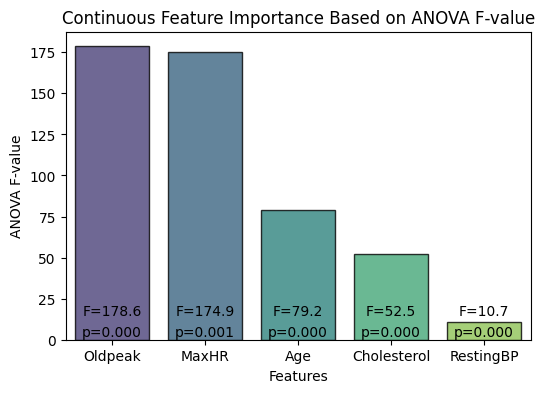

,ANOVA F-value,p-value,significant
Oldpeak,178.615120,3.007953e-18,True
MaxHR,174.913585,1.095315e-03,True
Age,79.160779,9.308309e-13,True
Cholesterol,52.459725,1.137786e-36,True
RestingBP,10.727228,2.390772e-37,True


In [66]:
# The SelectKBest class with f_classif function applies the ANOVA F-value statistical test
# for Feature Selection. It computes the F-value between label/feature for regression tasks.
# Here we choose 'k=all' to keep all features. I could also try to only keep the top k features.
selector = SelectKBest(score_func=f_classif, k="all")

# Perform feature selection. This computes the ANOVA F-value between each feature and the target variable.
fit = selector.fit(df2[continuous_feature_names], df2["HeartDisease"])

# Create a DataFrame to hold the ANOVA F-value for each feature.
# The F-value is a measure of the difference in variance between the distributions of the feature values
# conditioned on the target classes, relative to the combined variance.
anova_scores = pd.DataFrame(data=fit.scores_, index=continuous_feature_names, columns=["ANOVA F-value"])

# Sort the DataFrame by ANOVA F-value in descending order.
anova_scores = anova_scores.sort_values(by="ANOVA F-value", ascending=False)


anova_scores["p-value"] = fit.pvalues_  # calculate p-values
anova_scores["significant"] = anova_scores["p-value"] < 0.05  # add column to check for significance (p < 0.05)

# Create a bar plot of F-values, and annotate each bar with its p-value
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
barplot = sns.barplot(x=anova_scores.index, y=anova_scores["ANOVA F-value"], palette="viridis", ax=ax, edgecolor="black", alpha=0.8)
ax.set_title("Continuous Feature Importance Based on ANOVA F-value")
ax.set_xlabel("Features")
ax.set_ylabel('ANOVA F-value')

# Annotate each bar with its F-score and p-value
for i, (p_value, f_value) in enumerate(zip(anova_scores['p-value'], anova_scores["ANOVA F-value"])):
    barplot.text(i, 15, f'F={f_value:.1f}', color='black', ha='center')
    barplot.text(i, 2, f'p={p_value:.3f}', color='black', ha='center')

plt.savefig(os.path.join("visualizations", "ANOVA_results.png"), dpi=300)
plt.show()

# Display the DataFrame sorted by F-value
anova_scores = anova_scores.sort_values(by="ANOVA F-value", ascending=False)
anova_scores

ANOVA Takeaways:
1. All continuous variables have a significant effect on target variable
2. RestingBP has a relatively small F score (so more of the variance is unexplained)

### Chi-Squared test on categorical variables to determine feature importance

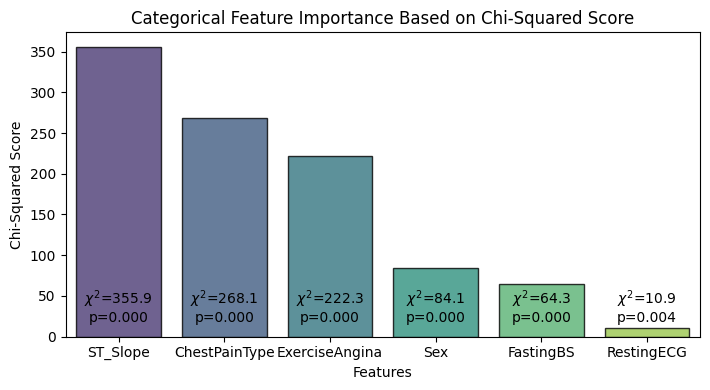

,Chi-Squared Score,p-value,Degrees of Freedom,significant
ST_Slope,355.918443,0.0,2,True
ChestPainType,268.067239,0.0,3,True
ExerciseAngina,222.259383,0.0,1,True
Sex,84.145101,0.0,1,True
FastingBS,64.320679,0.0,1,True
RestingECG,10.931469,0.004229,2,True


In [79]:
# Initialize a DataFrame to store the results
chisquare_scores = pd.DataFrame(index=categorical_feature_names, columns=["Chi-Squared Score", "p-value", "Degrees of Freedom"])

# Loop over each categorical feature
for feature in categorical_feature_names:
    # Create a contingency table
    contingency_table = pd.crosstab(df[feature], df["HeartDisease"])

    # Perform the Chi-squared test
    chi2, p, dof, _ = stats.chi2_contingency(contingency_table)

    # Save the results in the DataFrame
    chisquare_scores.loc[feature, "Chi-Squared Score"] = chi2
    chisquare_scores.loc[feature, "p-value"] = p
    chisquare_scores.loc[feature, "Degrees of Freedom"] = dof

# Add a "significant" column which is True when the p-value is less than 0.05 (indicating significance)
chisquare_scores["significant"] = chisquare_scores["p-value"] < 0.05

# Sort the DataFrame by chi-squared score in descending order.
chisquare_scores = chisquare_scores.sort_values(by="Chi-Squared Score", ascending=False)

fig, ax = plt.subplots(1, 1, figsize=(7.2, 4))
barplot = sns.barplot(x=chisquare_scores.index, y=chisquare_scores["Chi-Squared Score"], palette="viridis", ax=ax, edgecolor="black", alpha=0.8)
ax.set_title("Categorical Feature Importance Based on Chi-Squared Score")
ax.set_xlabel("Features")
ax.set_ylabel("Chi-Squared Score")

# Annotate each bar with its Chi-Squared score and p-value
for i, (p_value, chi2_score) in enumerate(zip(chisquare_scores["p-value"], chisquare_scores["Chi-Squared Score"])):
    chi2_str = f'$\chi^2$={chi2_score:.1f}'  # Chi-squared symbol with exponent using LaTeX
    barplot.text(i, 40, chi2_str, color="black", ha="center")
    barplot.text(i, 18, f"p={p_value:.3f}", color="black", ha="center")

plt.tight_layout()
plt.savefig(os.path.join("visualizations", "chi_sq_results.png"), dpi=300)
plt.show()

chisquare_scores

Chi-Squared test takeaways:
1. All categorical variables have a significant effect
2. Resting ECG has a p-value not much below 0.05, so if I were to remove any feature, it would be the best one to remove, even though it is statistically significant

# Modelling and Predicting

In [23]:
x_train, x_test, y_train, y_test = train_test_split(df2.drop("HeartDisease", axis=1), df2["HeartDisease"], test_size=0.2, random_state=1)

In [87]:
def calculate_results(y_true: np.ndarray, y_pred: np.ndarray) -> dict:
    """
    Calculates model accuracy, precision, recall and f1 score of a binary classification model.

    Args:
      y_true: true labels in the form of a 1D array
      y_pred: predicted labels in the form of a 1D array

    Returns a dictionary of accuracy, precision, recall, f1-score.
    """
    # Calculate model accuracy
    model_accuracy = accuracy_score(y_true, y_pred)
    # Calculate model precision, recall and f1 score using "weighted average
    model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="binary")

    # Calculate model specificity
    tn, fp, _, _ = confusion_matrix(y_true, y_pred).ravel()
    model_specificity = tn / (tn + fp)


    model_results = {"accuracy": model_accuracy,
                     "precision": model_precision,
                     "recall": model_recall,
                     "f1": model_f1,
                     "specificity": model_specificity}
    return model_results

def make_confusion_matrix(y_true, y_pred, classes=("Negative", "Positive"), figsize=(6, 6), text_size=15, save=False, title="Confusion Matrix", include_percent=False) -> np.ndarray[(2, 2), int]:
    """Makes a labelled confusion matrix comparing predictions and ground truth labels.

    If classes is passed, confusion matrix will be labelled, if not, integer class values
    will be used.

    Args:
        y_true: Array of truth labels (must be same shape as y_pred).
        y_pred: Array of predicted labels (must be same shape as y_true).
        classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
        figsize: Size of output figure (default=(10, 10)).
        text_size: Size of output figure text (default=15).
        include_percent (bool): whether to include percentages on the squares

    Returns:
        A labelled confusion matrix plot comparing y_true and y_pred.

    Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
    """
    plt.style.use("default")
    # Create the confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]  # normalize it
    n_classes = cm.shape[0]  # find the number of classes we're dealing with

    # Plot the figure and make it pretty
    fig, ax = plt.subplots(figsize=figsize)
    cax = ax.matshow(cm, cmap=plt.cm.Blues)  # colors will represent how 'correct' a class is, darker == better
    fig.colorbar(cax)

    # If there are labels for the classes, add them
    if classes is not None:
        labels = classes
    else:
        labels = np.arange(cm.shape[0])

    # Label the axes
    ax.set(title=title,
           xlabel="Predicted label",
           ylabel="True label",
           xticks=np.arange(n_classes),  # create enough axis slots for each class
           yticks=np.arange(n_classes),
           xticklabels=labels,  # axes will be labeled with class names (if they exist) or ints
           yticklabels=labels)

    # Make x-axis labels appear on bottom
    ax.xaxis.set_label_position("bottom")
    ax.xaxis.tick_bottom()

    # Set the threshold for different colors
    threshold = (cm.max() + cm.min()) / 2.

    # Plot the text on each cell
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if include_percent:
            plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
                     horizontalalignment="center",
                     color="white" if cm[i, j] > threshold else "black",
                     size=text_size)
        else:
            plt.text(j, i, f"{cm[i, j]}",
                     horizontalalignment="center",
                     color="white" if cm[i, j] > threshold else "black",
                     size=text_size)

    if save:
        plt.savefig(os.path.join("visualizations", f"{title}.png"), dpi=300, bbox_inches="tight")
        if title == "Confusion Matrix":
            print("Warning! default title on saved confusion matrix")
    plt.show()
    return cm

Initialize dataframe to easily keep track of experiments in an organized way

In [121]:
models_df = pd.DataFrame({"experiment_name": [], "predictions": [], "accuracy": [], "precision": [], "recall": [], "f1": [], "specificity": []})
models_df["predictions"] = models_df["predictions"].astype(object)  # this line is needed to enable numpy arrays to enter the "predictions" column
def add_experiment(models: pd.DataFrame, experiment_name: str, predictions: np.ndarray, testing_y: np.ndarray = y_test) -> pd.DataFrame:
    """
    Add a new experiment to the models_df DataFrame.

    Args:
        models: DataFrame to store the models' results.
        experiment_name: Name of the experiment.
        predictions: The model's predicted labels as a numpy array.
        testing_y: y_test for the model being evaluated

    Returns:
        Updated models DataFrame with the new experiment.
    """
    if experiment_name in models["experiment_name"].values:
        # Experiment name already exists in the DataFrame
        print(f"{experiment_name} already exists in the dataframe. Skipping addition.")
        return models

    # Convert the predictions array to a string representation
    # predictions_str = np.array2string(predictions, separator=",")[0:-1]
    # predictions_str = predictions
    # Create a new row dictionary with experiment name, predictions, and other results
    new_row = {"experiment_name": experiment_name, "predictions": predictions}
    results = calculate_results(y_true=testing_y, y_pred=predictions)
    new_row.update(results)

    # Add the new row to the DataFrame
    models.loc[len(models)] = new_row
    return models


/var/folders/yh/cbw5x_lj4_g_fj7lht06nbt00000gn/T/ipykernel_16946/1053811970.py:16: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if experiment_name in models["experiment_name"].values:


,experiment_name,predictions,accuracy,precision,recall,f1,specificity
0,logistic_regressor1,"[1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, ...",0.896739,0.90991,0.918182,0.914027,0.864865


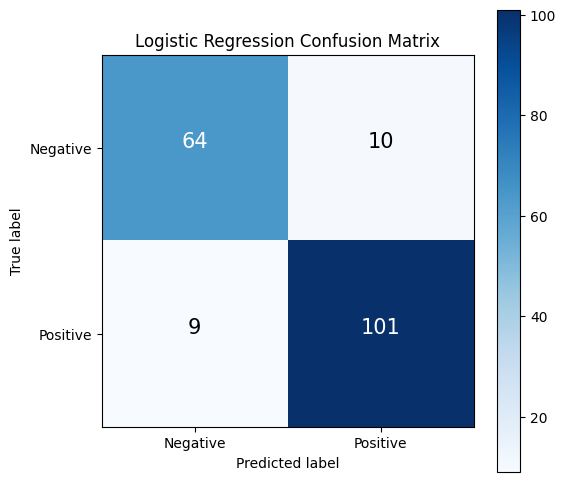

In [124]:
logistic_regressor1 = LogisticRegression(random_state=10)
logistic_regressor1.fit(x_train, y_train)

logistic_regressor1_predictions = logistic_regressor1.predict(x_test)
models_df = add_experiment(models_df, "logistic_regressor1", logistic_regressor1_predictions)
display(models_df)
logistic_regressor1_cm = make_confusion_matrix(y_true=y_test, y_pred=logistic_regressor1_predictions, figsize=(6, 6), title="Logistic Regression Confusion Matrix", save=True, include_percent=False)

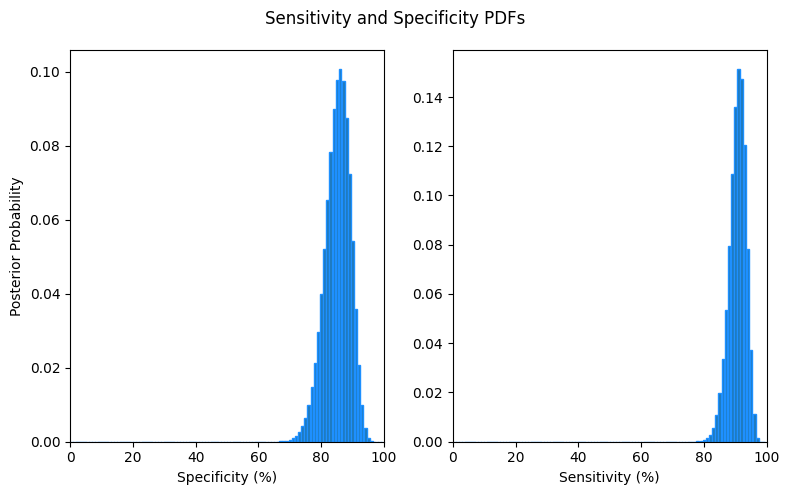

Sensitivity mode = 91.5, 95% CI: (86.5, 95.5)
Sensitivity mode = 86.5, 95% CI: (78.5, 92.5)


In [90]:
from sensitivity_specificity import sensitivity_specificity_pdfs
(specificity_mode, (specificity_min_95, specificity_max_95)), (sensitivity_mode, (sensitivity_min_95, sensitivity_max_95)),  = sensitivity_specificity_pdfs(logistic_regressor1_cm, save=True, hypotheses=100)
print(f"Sensitivity mode = {sensitivity_mode}, 95% CI: ({sensitivity_min_95}, {sensitivity_max_95})")
print(f"Sensitivity mode = {specificity_mode}, 95% CI: ({specificity_min_95}, {specificity_max_95})")

,experiment_name,predictions,accuracy,precision,recall,f1,specificity
0,logistic_regressor1,"[1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, ...",0.896739,0.909910,0.918182,0.914027,0.864865
1,random_forest1,"[1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, ...",0.902174,0.910714,0.927273,0.918919,0.864865


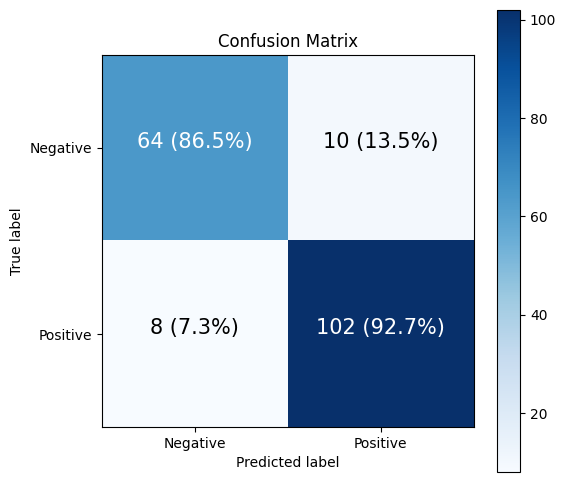

array([[ 64,  10],
       [  8, 102]])

In [27]:
random_forest1 = RandomForestClassifier(random_state=10)
random_forest1.fit(x_train, y_train)
random_forest1_predictions = random_forest1.predict(x_test)

models_df = add_experiment(models_df, "random_forest1", random_forest1_predictions)
display(models_df)
make_confusion_matrix(y_true=y_test, y_pred=random_forest1_predictions, figsize=(6, 6))

,experiment_name,predictions,accuracy,precision,recall,f1,specificity
0,logistic_regressor1,"[1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, ...",0.896739,0.909910,0.918182,0.914027,0.864865
1,random_forest1,"[1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, ...",0.902174,0.910714,0.927273,0.918919,0.864865
2,svm_model1,"[1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, ...",0.907609,0.911504,0.936364,0.923767,0.864865


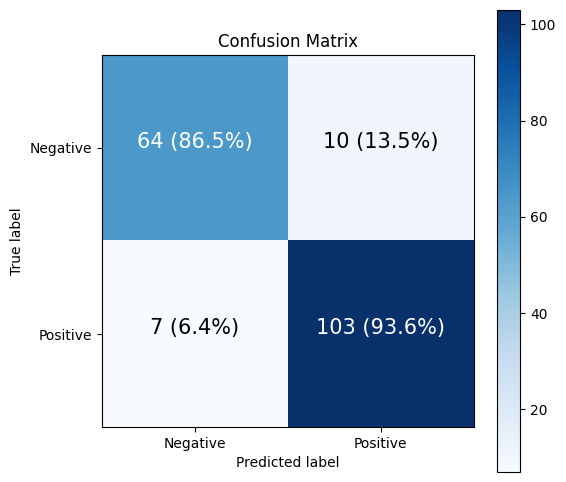

array([[ 64,  10],
       [  7, 103]])

In [28]:
svm_model1 = SVC(random_state=10)
svm_model1.fit(x_train, y_train)

svm_model1_predictions = svm_model1.predict(x_test)

models_df = add_experiment(models_df, "svm_model1", svm_model1_predictions)
display(models_df)
make_confusion_matrix(y_true=y_test, y_pred=svm_model1_predictions, figsize=(6, 6))

,experiment_name,predictions,accuracy,precision,recall,f1,specificity
0,logistic_regressor1,"[1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, ...",0.896739,0.909910,0.918182,0.914027,0.864865
1,random_forest1,"[1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, ...",0.902174,0.910714,0.927273,0.918919,0.864865
2,svm_model1,"[1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, ...",0.907609,0.911504,0.936364,0.923767,0.864865
3,gnb_model1,"[1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, ...",0.902174,0.925926,0.909091,0.917431,0.891892


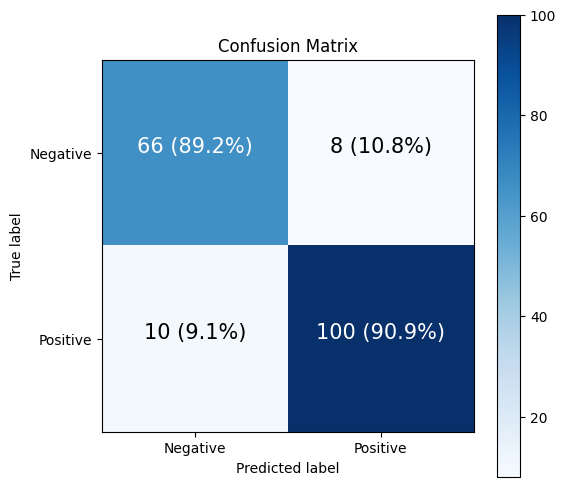

,experiment_name,predictions,accuracy,precision,recall,f1,specificity
0,logistic_regressor1,"[1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, ...",0.896739,0.909910,0.918182,0.914027,0.864865
1,random_forest1,"[1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, ...",0.902174,0.910714,0.927273,0.918919,0.864865
2,svm_model1,"[1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, ...",0.907609,0.911504,0.936364,0.923767,0.864865
3,gnb_model1,"[1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, ...",0.902174,0.925926,0.909091,0.917431,0.891892
4,bnb_model1,"[1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, ...",0.907609,0.934579,0.909091,0.921659,0.905405


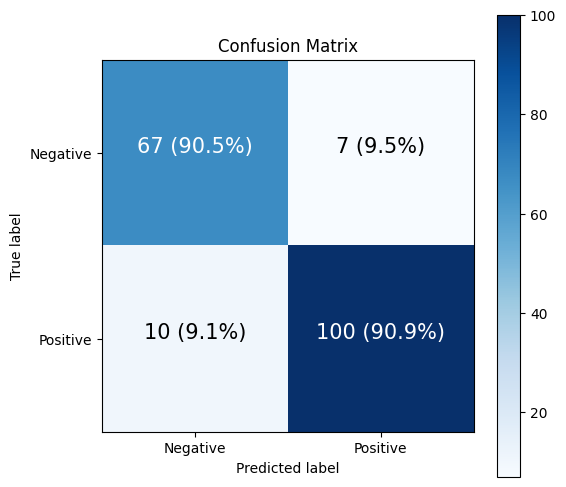

array([[ 67,   7],
       [ 10, 100]])

In [29]:
# Gaussian Naive Bayes
gnb_model1 = GaussianNB()
gnb_model1.fit(x_train, y_train)
gnb_predictions = gnb_model1.predict(x_test)

models_df = add_experiment(models_df, "gnb_model1", gnb_predictions)
display(models_df)
make_confusion_matrix(y_true=y_test, y_pred=gnb_predictions, figsize=(6, 6))

# Bernoulli Naive Bayes
bnb_model1 = BernoulliNB()
bnb_model1.fit(x_train, y_train)
bnb_predictions = bnb_model1.predict(x_test)


models_df = add_experiment(models_df, "bnb_model1", bnb_predictions)
display(models_df)
make_confusion_matrix(y_true=y_test, y_pred=bnb_predictions, figsize=(6, 6))

,experiment_name,predictions,accuracy,precision,recall,f1,specificity
0,logistic_regressor1,"[1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, ...",0.896739,0.909910,0.918182,0.914027,0.864865
1,random_forest1,"[1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, ...",0.902174,0.910714,0.927273,0.918919,0.864865
2,svm_model1,"[1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, ...",0.907609,0.911504,0.936364,0.923767,0.864865
3,gnb_model1,"[1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, ...",0.902174,0.925926,0.909091,0.917431,0.891892
4,bnb_model1,"[1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, ...",0.907609,0.934579,0.909091,0.921659,0.905405
5,XGB_model1,"[1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, ...",0.880435,0.907407,0.890909,0.899083,0.864865


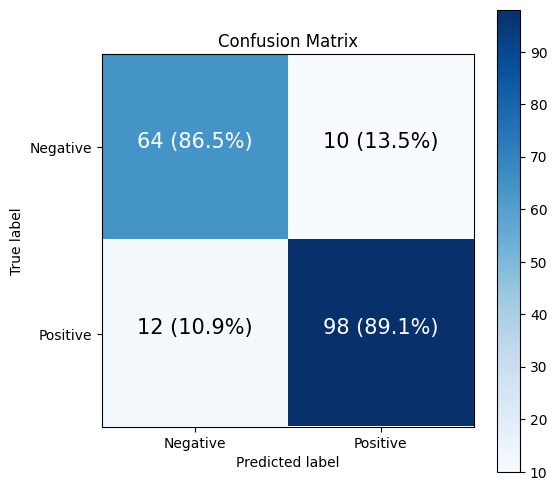

array([[64, 10],
       [12, 98]])

In [30]:
XGB_model1 = XGBClassifier()
XGB_model1.fit(x_train, y_train)

XGB_model1_predictions = XGB_model1.predict(x_test)

models_df = add_experiment(models_df, "XGB_model1", XGB_model1_predictions)
display(models_df)
make_confusion_matrix(y_true=y_test, y_pred=XGB_model1_predictions, figsize=(6, 6))

In [31]:
# trying a deeplearning model
tf.random.set_seed(10)

dl_model1 = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(len(x_train.columns),)),
    tf.keras.layers.Dense(110, activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

dl_model1.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                  optimizer=tf.keras.optimizers.Adam(),
                  metrics=["accuracy"])

dl_model1_history = dl_model1.fit(x_train, y_train, epochs=5, validation_data=(x_test, y_test))

Epoch 1/5


2023-05-28 18:19:00.035721: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


23/23 [==============================] - 0s 5ms/step - loss: 0.6324 - accuracy: 0.5954 - val_loss: 0.5212 - val_accuracy: 0.7391
Epoch 2/5
23/23 [==============================] - 0s 972us/step - loss: 0.5378 - accuracy: 0.7507 - val_loss: 0.4442 - val_accuracy: 0.8261
Epoch 3/5
23/23 [==============================] - 0s 1ms/step - loss: 0.4723 - accuracy: 0.8324 - val_loss: 0.3669 - val_accuracy: 0.8967
Epoch 4/5
23/23 [==============================] - 0s 1ms/step - loss: 0.4023 - accuracy: 0.8529 - val_loss: 0.3080 - val_accuracy: 0.8967
Epoch 5/5
23/23 [==============================] - 0s 1ms/step - loss: 0.3648 - accuracy: 0.8529 - val_loss: 0.2876 - val_accuracy: 0.8859


6/6 [==============================] - 0s 460us/step


,experiment_name,predictions,accuracy,precision,recall,f1,specificity
0,logistic_regressor1,"[1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, ...",0.896739,0.909910,0.918182,0.914027,0.864865
1,random_forest1,"[1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, ...",0.902174,0.910714,0.927273,0.918919,0.864865
2,svm_model1,"[1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, ...",0.907609,0.911504,0.936364,0.923767,0.864865
3,gnb_model1,"[1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, ...",0.902174,0.925926,0.909091,0.917431,0.891892
4,bnb_model1,"[1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, ...",0.907609,0.934579,0.909091,0.921659,0.905405
5,XGB_model1,"[1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, ...",0.880435,0.907407,0.890909,0.899083,0.864865
6,dl_model1,"[1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",0.885870,0.923810,0.881818,0.902326,0.891892


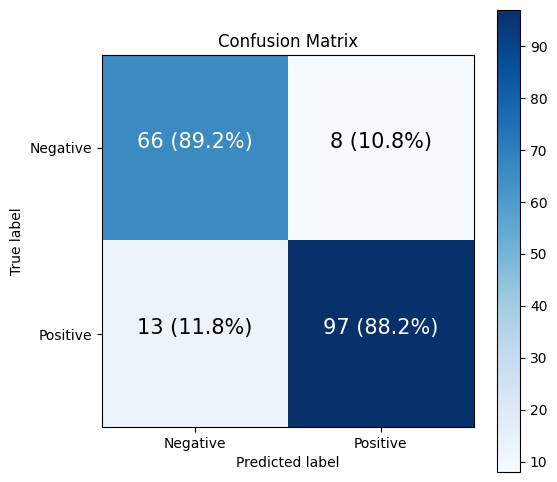

In [32]:
dl_model1_preds = np.round(dl_model1.predict(x_test)).flatten()
models_df = add_experiment(models_df, "dl_model1", dl_model1_preds)
display(models_df)
dl_model1_cm = make_confusion_matrix(y_test, dl_model1_preds)

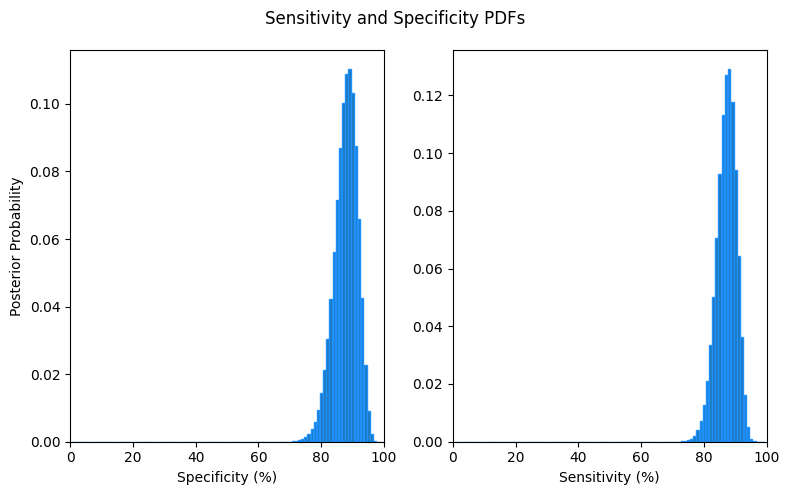

Sensitivity mode = 89.5, 95% CI: (81.5, 94.5)
Sensitivity mode = 88.5, 95% CI: (81.5, 92.5)


In [33]:
# sensitivity specificity uncertainty (evaluated by Bayesian model)
from sensitivity_specificity import sensitivity_specificity_pdfs
(sensitivity_mode, (sensitivity_min_95, sensitivity_max_95)), (specificity_mode, (specificity_min_95, specificity_max_95)) = sensitivity_specificity_pdfs(dl_model1_cm, save=False, hypotheses=100)
print(f"Sensitivity mode = {sensitivity_mode}, 95% CI: ({sensitivity_min_95}, {sensitivity_max_95})")
print(f"Sensitivity mode = {specificity_mode}, 95% CI: ({specificity_min_95}, {specificity_max_95})")

# Trying to improve models by dealing with missing cholesterol values

### Cholesterol Imputation: Replace 0 Cholesterol Values With the Mean

In [34]:
display(df["Cholesterol"].describe())  # unedited cholesterol description
display(df[df["Cholesterol"]!=0]["Cholesterol"].describe())  # cholesterol description excluding 0s

count    918.000000
mean     198.799564
std      109.384145
min        0.000000
25%      173.250000
50%      223.000000
75%      267.000000
max      603.000000
Name: Cholesterol, dtype: float64

count    746.000000
mean     244.635389
std       59.153524
min       85.000000
25%      207.250000
50%      237.000000
75%      275.000000
max      603.000000
Name: Cholesterol, dtype: float64

In [35]:
df3 = df.copy(deep=True)  # make a new dataframe for this
df3["FastingBS"] = df3["FastingBS"].astype(int)

df3.loc[df3["Cholesterol"]==0, "Cholesterol"] = df3[df3["Cholesterol"]!=0]["Cholesterol"].mean()
  # set it equal to the mean
display(df3["Cholesterol"].describe())

count    918.000000
mean     244.635389
std       53.318029
min       85.000000
25%      214.000000
50%      244.635389
75%      267.000000
max      603.000000
Name: Cholesterol, dtype: float64

### Try models again and compare performance

create function to run all of the above experiments on new data

In [122]:
def run_models(df, continuous_feature_names, categorical_feature_names, models_df_, add_experiment, descriptor="New", preprocessed=False):
    """
    Run and evaluate machine learning models on the provided dataset.

    Args:
        df (pd.DataFrame): Input DataFrame containing the dataset.
        continuous_feature_names (list): List of continuous feature names.
        categorical_feature_names (list): List of categorical feature names.
        models_df_ (pd.DataFrame): DataFrame to store the models' results.
        add_experiment (function): Function to add a new experiment to the models DataFrame.
        descriptor (int or str, optional): Descriptor to differentiate the models. Defaults to "New".
        preprocessed (bool): Whether the data has been preprocessed. If False, does preprocessing. Defaults to False

    Returns:
        pd.DataFrame: Updated models DataFrame with the results of the experiments.
    """
    if not preprocessed:
        min_max_scaler = MinMaxScaler()
        standard_scaler = StandardScaler()

        # Apply both scalers to each continuous variable
        for feature in continuous_feature_names:
            # Perform MinMax scaling
            min_max_scaled_data = min_max_scaler.fit_transform(df[[feature]])

            # Perform Standard scaling on the MinMax scaled data
            min_max_standard_scaled_data = standard_scaler.fit_transform(min_max_scaled_data)

            # Update the original DataFrame with the scaled data
            df[feature] = min_max_standard_scaled_data.flatten()

        # One hot encoding of categorical variables
        df = pd.get_dummies(df, columns=categorical_feature_names, dtype=int, drop_first=True)

    # Splitting the data
    x_train, x_test, y_train, y_test = train_test_split(df.drop("HeartDisease", axis=1), df["HeartDisease"], test_size=0.2, random_state=1)
    y_train, y_test = y_train.astype(int), y_test.astype(int)

    # Models to be used
    models = {
        f"logistic_regressor_{descriptor}": LogisticRegression(random_state=10),
        f"random_forest_{descriptor}": RandomForestClassifier(random_state=10),
        f"svm_model_{descriptor}": SVC(random_state=10),
        f"gnb_model_{descriptor}": GaussianNB(),
        f"bnb_model_{descriptor}": BernoulliNB(),
        f"XGB_model_{descriptor}": XGBClassifier(random_state=10)
    }

    # Training and evaluating the models
    for model_name, model in models.items():
        model.fit(x_train, y_train)
        predictions = model.predict(x_test)
        models_df_ = add_experiment(models_df_, model_name, predictions)


    # Training and evaluating the deep learning model
    tf.random.set_seed(10)

    dl_model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=(len(x_train.columns),)),
        tf.keras.layers.Dense(110, activation="relu"),
        tf.keras.layers.Dense(10, activation="relu"),
        tf.keras.layers.Dense(1, activation="sigmoid")
    ])

    dl_model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

    dl_model.fit(x_train, y_train, epochs=5, validation_data=(x_test, y_test), verbose=False)
    dl_model_preds = np.round(dl_model.predict(x_test)).flatten()
    models_df_ = add_experiment(models_df_, f"dl_model_{descriptor}", dl_model_preds, y_test)

    return models_df_


In [37]:
models_df = run_models(df3.copy(deep=True), continuous_feature_names, categorical_feature_names, models_df, add_experiment, descriptor="mean_imputation")
display(models_df.drop("predictions", axis=1).sort_values(by="experiment_name", ascending=False))

6/6 [==============================] - 0s 1ms/step


,experiment_name,accuracy,precision,recall,f1,specificity
9,svm_model_mean_imputation,0.913043,0.927273,0.927273,0.927273,0.891892
2,svm_model1,0.907609,0.911504,0.936364,0.923767,0.864865
8,random_forest_mean_imputation,0.885870,0.915888,0.890909,0.903226,0.878378
1,random_forest1,0.902174,0.910714,0.927273,0.918919,0.864865
7,logistic_regressor_mean_imputation,0.918478,0.927928,0.936364,0.932127,0.891892
0,logistic_regressor1,0.896739,0.909910,0.918182,0.914027,0.864865
10,gnb_model_mean_imputation,0.907609,0.926606,0.918182,0.922374,0.891892
3,gnb_model1,0.902174,0.925926,0.909091,0.917431,0.891892
13,dl_model_mean_imputation,0.907609,0.918919,0.927273,0.923077,0.878378
6,dl_model1,0.885870,0.923810,0.881818,0.902326,0.891892


## Attempt 2: replace all 0 cholesterol values with the median, then mode

In [38]:
display(df[df["Cholesterol"]!=0]["Cholesterol"].median())

237.0

In [39]:
df4 = df.copy(deep=True)  # make a new dataframe for this
df4["FastingBS"] = df4["FastingBS"].astype(int)

df4.loc[df4["Cholesterol"]==0, "Cholesterol"] = df4[df4["Cholesterol"]!=0]["Cholesterol"].median() # set it equal to the median

display(df4["Cholesterol"].describe())

count    918.000000
mean     243.204793
std       53.401297
min       85.000000
25%      214.000000
50%      237.000000
75%      267.000000
max      603.000000
Name: Cholesterol, dtype: float64

In [40]:
models_df = run_models(df4.copy(deep=True), continuous_feature_names, categorical_feature_names, models_df, add_experiment, descriptor="median_imputation")
display(models_df.drop("predictions", axis=1).sort_values(by="experiment_name", ascending=False))

6/6 [==============================] - 0s 556us/step


,experiment_name,accuracy,precision,recall,f1,specificity
16,svm_model_median_imputation,0.907609,0.926606,0.918182,0.922374,0.891892
9,svm_model_mean_imputation,0.913043,0.927273,0.927273,0.927273,0.891892
2,svm_model1,0.907609,0.911504,0.936364,0.923767,0.864865
15,random_forest_median_imputation,0.891304,0.916667,0.900000,0.908257,0.878378
8,random_forest_mean_imputation,0.885870,0.915888,0.890909,0.903226,0.878378
1,random_forest1,0.902174,0.910714,0.927273,0.918919,0.864865
14,logistic_regressor_median_imputation,0.918478,0.927928,0.936364,0.932127,0.891892
7,logistic_regressor_mean_imputation,0.918478,0.927928,0.936364,0.932127,0.891892
0,logistic_regressor1,0.896739,0.909910,0.918182,0.914027,0.864865
17,gnb_model_median_imputation,0.907609,0.926606,0.918182,0.922374,0.891892


In [41]:
df5 = df.copy(deep=True)  # make a new dataframe for this
df5["FastingBS"] = df5["FastingBS"].astype(int)

df5.loc[df5["Cholesterol"]==0, "Cholesterol"] = df5[df5["Cholesterol"]!=0]["Cholesterol"].mode()[0]
  # set it equal to the mean
display(df5["Cholesterol"].describe())

count    918.000000
mean     246.389978
std       53.443234
min       85.000000
25%      214.000000
50%      254.000000
75%      267.000000
max      603.000000
Name: Cholesterol, dtype: float64

In [42]:
print(df5[df5["Cholesterol"]!=0]["Cholesterol"].median())
print(df5[df5["Cholesterol"]!=0]["Cholesterol"].mode()[0])  # need to add the 0 at the end for mode

254.0
254


In [43]:
models_df = run_models(df5.copy(deep=True), continuous_feature_names, categorical_feature_names, models_df, add_experiment, descriptor="mode_imputation")
display(models_df.drop("predictions", axis=1).sort_values(by="experiment_name", ascending=False))

6/6 [==============================] - 0s 2ms/step


,experiment_name,accuracy,precision,recall,f1,specificity
23,svm_model_mode_imputation,0.918478,0.927928,0.936364,0.932127,0.891892
16,svm_model_median_imputation,0.907609,0.926606,0.918182,0.922374,0.891892
9,svm_model_mean_imputation,0.913043,0.927273,0.927273,0.927273,0.891892
2,svm_model1,0.907609,0.911504,0.936364,0.923767,0.864865
22,random_forest_mode_imputation,0.896739,0.917431,0.909091,0.913242,0.878378
15,random_forest_median_imputation,0.891304,0.916667,0.900000,0.908257,0.878378
8,random_forest_mean_imputation,0.885870,0.915888,0.890909,0.903226,0.878378
1,random_forest1,0.902174,0.910714,0.927273,0.918919,0.864865
21,logistic_regressor_mode_imputation,0.918478,0.927928,0.936364,0.932127,0.891892
14,logistic_regressor_median_imputation,0.918478,0.927928,0.936364,0.932127,0.891892


In [123]:
delete_null_df = df.copy(deep=True)
delete_null_df = delete_null_df[delete_null_df["Cholesterol"]!=0]

delete_null_df["FastingBS"] = delete_null_df["FastingBS"].astype(int)

# display(delete_null_df["Cholesterol"])
display(delete_null_df["Cholesterol"].describe())
models_df = run_models(delete_null_df, continuous_feature_names, categorical_feature_names, models_df, add_experiment, descriptor="delete_null")
# display(models_df.drop("predictions", axis=1).sort_values(by="experiment_name", ascending=False))

count    746.000000
mean     244.635389
std       59.153524
min       85.000000
25%      207.250000
50%      237.000000
75%      275.000000
max      603.000000
Name: Cholesterol, dtype: float64

/var/folders/yh/cbw5x_lj4_g_fj7lht06nbt00000gn/T/ipykernel_16946/1053811970.py:16: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if experiment_name in models["experiment_name"].values:


ValueError: Found input variables with inconsistent numbers of samples: [184, 150]

### Cholesterol Imputation method 2: predicting most probable values with Regression
- This is essentially another machine learning question: now the target variable is cholesterol, and I can use all features (including presence of heart disease)

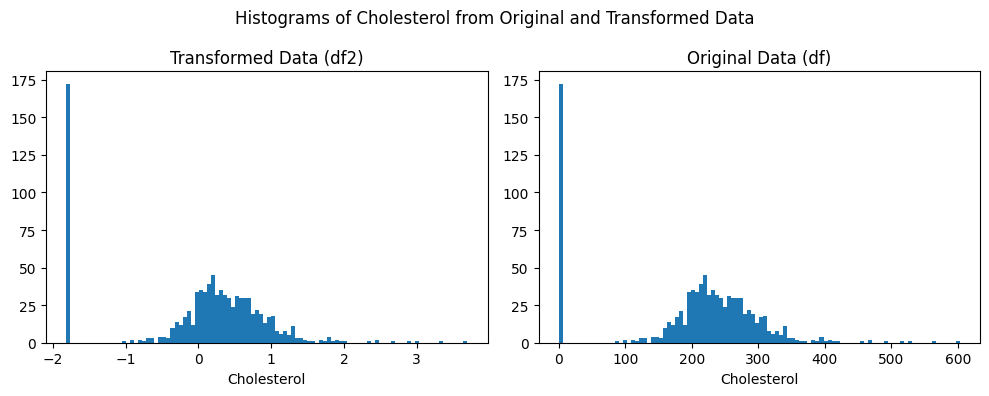

In [44]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

ax[0].hist(df2["Cholesterol"], bins=100)
ax[0].set_title("Transformed Data (df2)")
ax[0].set_xlabel("Cholesterol")

ax[1].hist(df["Cholesterol"], bins=100)
ax[1].set_title("Original Data (df)")
ax[1].set_xlabel("Cholesterol")

plt.suptitle("Histograms of Cholesterol from Original and Transformed Data")
plt.tight_layout()
plt.show()

In [45]:
# Select rows from regularized normalized where Cholesterol is not the mode, because the mode is the transformed equivalent of 0
full_train_regression = df2[df2["Cholesterol"]!=df2["Cholesterol"].mode()[0]]

x_reg = full_train_regression.drop("Cholesterol", axis=1)
y_reg = full_train_regression["Cholesterol"]

needs_cholesterol = df2[df2["Cholesterol"]==df2["Cholesterol"].mode()[0]]  # get dataframe with all the cholesterol null vales
needs_cholesterol = needs_cholesterol.drop("Cholesterol", axis=1)  # remove the cholesterol column, so we can feed this data into regression models

In [46]:
x_train_reg, x_test_reg, y_train_reg, y_test_reg = train_test_split(x_reg, y_reg, test_size=0.2, random_state=10)

In [47]:
from sklearn.linear_model import LinearRegression
chol_linear_regression1 = LinearRegression()
chol_linear_regression1.fit(x_train_reg, y_train_reg)

chol_linear_regression1_pred = chol_linear_regression1.predict(x_test_reg)

# Now you can calculate RMSE, MAE, and R^2 to evaluate the model's performance
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

rmse = np.sqrt(mean_squared_error(y_test_reg, chol_linear_regression1_pred))
mae = mean_absolute_error(y_test_reg, chol_linear_regression1_pred)
r2 = r2_score(y_test_reg, chol_linear_regression1_pred)

print(f"chol_linear_regression1 metrics:\n"
      f"RMSE: {rmse}, MAE: {mae}, R^2: {r2}")


chol_linear_regression1 metrics:
RMSE: 0.5292842845745269, MAE: 0.38590078809373296, R^2: 0.0005779811317074834


In [48]:
from sklearn.linear_model import Ridge

ridge_regression1 = Ridge(alpha=0.5, random_state=10)
ridge_regression1.fit(x_train_reg, y_train_reg)
ridge_regression1_pred = ridge_regression1.predict(x_test_reg)

rmse = np.sqrt(mean_squared_error(y_test_reg, ridge_regression1_pred))
mae = mean_absolute_error(y_test_reg, ridge_regression1_pred)
r2 = r2_score(y_test_reg, ridge_regression1_pred)

print(f"ridge_regression1_pred metrics:\n"
      f"RMSE: {rmse}, MAE: {mae}, R^2: {r2}")
adjusted_cholesterol_range = full_train_regression['Cholesterol'].max()-full_train_regression['Cholesterol'].min()
print(f"Range: {adjusted_cholesterol_range}")
print(f"RMSE/Range = {rmse/adjusted_cholesterol_range}")

ridge_regression1_pred metrics:
RMSE: 0.5291853877528877, MAE: 0.38581679611183567, R^2: 0.0009514304477832303
Range: 4.738185483005347
RMSE/Range = 0.11168524103814416


In [49]:
from sklearn.linear_model import Lasso

lasso_regression1 = Lasso(alpha=0.1, random_state=10)
lasso_regression1.fit(x_train_reg, y_train_reg)
lasso_regression1_pred = lasso_regression1.predict(x_test_reg)

rmse = np.sqrt(mean_squared_error(y_test_reg, lasso_regression1_pred))
mae = mean_absolute_error(y_test_reg, lasso_regression1_pred)
r2 = r2_score(y_test_reg, lasso_regression1_pred)

print(f"lasso_regression1_pred metrics:\n"
      f"RMSE: {rmse}, MAE: {mae}, R^2: {r2}") # how is R^2 negative
# THIS SEEMS TO GIVE ALL THE SAME NUMBERS AS PREDICTION WHEN I TRY ON NEEDS_CHOLESTEROL DF

lasso_regression1_pred metrics:
RMSE: 0.5319257720721704, MAE: 0.3974071067365232, R^2: -0.00942249854267585


In [50]:
from sklearn.preprocessing import PolynomialFeatures
# Create polynomial features
degree = 3  # Set the degree of the polynomial
poly_features = PolynomialFeatures(degree=degree)
x_train_poly = poly_features.fit_transform(x_train_reg)

# Fit linear regression model on polynomial features
poly_regression = LinearRegression()
poly_regression.fit(x_train_poly, y_train_reg)

# Assume x_test_reg is your test data

# Transform test data to polynomial features
x_test_poly = poly_features.transform(x_test_reg)

# Predict cholesterol using the polynomial regression model
y_test_pred = poly_regression.predict(x_test_poly)


rmse = np.sqrt(mean_squared_error(y_test_reg, y_test_pred))
mae = mean_absolute_error(y_test_reg, y_test_pred)
r2 = r2_score(y_test_reg, y_test_pred)

print(f"Polynomial Regression metrics:\n"
      f"RMSE: {rmse}, MAE: {mae}, R^2: {r2}")

Polynomial Regression metrics:
RMSE: 48706010.42447098, MAE: 14212043.052720867, R^2: -8463227782755418.0


In [51]:
from sklearn.ensemble import RandomForestRegressor

random_forest_regression1 = RandomForestRegressor()
random_forest_regression1.fit(x_train_reg, y_train_reg)
random_forest_regression1_pred = random_forest_regression1.predict(x_test_reg)

rmse = np.sqrt(mean_squared_error(y_test_reg, random_forest_regression1_pred))
mae = mean_absolute_error(y_test_reg, random_forest_regression1_pred)
r2 = r2_score(y_test_reg, random_forest_regression1_pred)

print(f"random_forest_regression1_pred metrics:\n"
      f"RMSE: {rmse}, MAE: {mae}, R^2: {r2}")
# still super low R^2

random_forest_regression1_pred metrics:
RMSE: 0.5195948050878747, MAE: 0.3820752032089381, R^2: 0.036835392176455484


In [109]:
from sklearn.svm import SVR

svr_regression1 = SVR()
svr_regression1.fit(x_train_reg, y_train_reg)
svr_regression_pred = svr_regression1.predict(x_test_reg)

rmse = np.sqrt(mean_squared_error(y_test_reg, svr_regression_pred))
mae = mean_absolute_error(y_test_reg, svr_regression_pred)
r2 = r2_score(y_test_reg, svr_regression_pred)

print(f"svr_regression_pred metrics:\n"
      f"RMSE: {rmse}, MAE: {mae}, R^2: {r2}")


svr_regression_pred metrics:
RMSE: 0.5255934698111095, MAE: 0.382494249840097, R^2: 0.014467758927001473


In [ ]:
from xgboost import XGBRegressor



5/5 [==============================] - 0s 1ms/step
reg_dl1_pred metrics:
RMSE: 0.5236486546543193, MAE: 0.38339939927693545, R^2: 0.021747651383423938


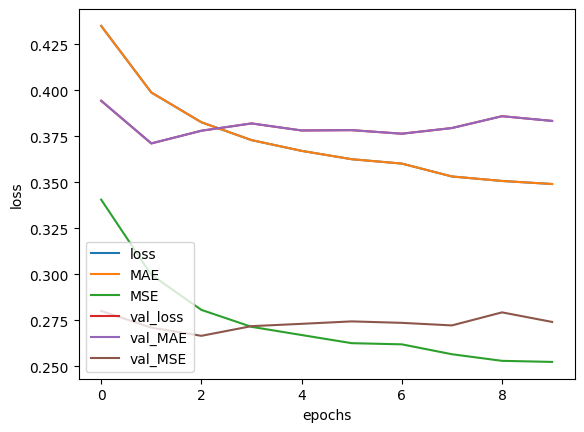

In [111]:
tf.random.set_seed(10)
reg_dl1 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1)
])

reg_dl1.compile(loss=tf.keras.losses.mae,
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["MAE", "MSE"])

reg_dl1_history = reg_dl1.fit(x_train_reg, y_train_reg, epochs=10, validation_data=(x_test_reg, y_test_reg), verbose=False)
pd.DataFrame(reg_dl1_history.history).plot()
plt.xlabel("epochs")
plt.ylabel("loss")

reg_dl1_pred = reg_dl1.predict(x_test_reg)

rmse = np.sqrt(mean_squared_error(y_test_reg, reg_dl1_pred))
mae = mean_absolute_error(y_test_reg, reg_dl1_pred)
r2 = r2_score(y_test_reg, reg_dl1_pred)

print(f"reg_dl1_pred metrics:\n"
      f"RMSE: {rmse}, MAE: {mae}, R^2: {r2}")

In [57]:
needs_cholesterol_dl = needs_cholesterol.copy(deep=True)
needs_cholesterol_dl["Cholesterol"] = reg_dl1.predict(needs_cholesterol)
regressed_df2 = pd.concat([full_train_regression, needs_cholesterol_dl], axis=0)  # combine the dataframes
display(regressed_df2)

6/6 [==============================] - 0s 466us/step


,Age,RestingBP,Cholesterol,MaxHR,Oldpeak,HeartDisease,Sex_F,Sex_M,ChestPainType_ASY,ChestPainType_ATA,...,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ExerciseAngina_N,ExerciseAngina_Y,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up,FastingBS_0,FastingBS_1
0,-1.433140,0.410909,0.825070,1.382928,-0.832432,0,0,1,0,1,...,0,1,0,1,0,0,0,1,1,0
1,-0.478484,1.491752,-0.171961,0.754157,0.105664,1,1,0,0,0,...,0,1,0,1,0,0,1,0,1,0
2,-1.751359,-0.129513,0.770188,-1.525138,-0.832432,0,0,1,0,1,...,0,0,1,1,0,0,0,1,1,0
3,-0.584556,0.302825,0.139040,-1.132156,0.574711,1,1,0,1,0,...,0,1,0,0,1,0,1,0,1,0
4,0.051881,0.951331,-0.034755,-0.581981,-0.832432,0,0,1,0,0,...,0,1,0,1,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
514,-1.114921,-0.561850,0.341365,-0.660578,-0.363384,1,0,1,1,0,...,0,1,0,1,0,0,0,1,1,0
515,1.006537,-0.129513,0.218095,0.911350,1.981855,0,0,1,0,0,...,0,0,1,1,0,0,1,0,0,1
518,-0.584556,-1.642694,0.348908,-1.053560,0.105664,1,0,1,0,0,...,0,0,1,0,1,1,0,0,0,1
535,0.264027,-0.129513,0.511948,-0.581981,0.105664,1,0,1,1,0,...,1,0,0,0,1,0,1,0,1,0


In [59]:
models_df = run_models(regressed_df2.copy(deep=True), continuous_feature_names, categorical_feature_names, models_df, add_experiment, descriptor="dl", preprocessed=True)
display(models_df.drop("predictions", axis=1).sort_values(by="experiment_name", ascending=False))
# DL regression sucks

6/6 [==============================] - 0s 920us/step


,experiment_name,accuracy,precision,recall,f1,specificity
23,svm_model_mode_imputation,0.918478,0.927928,0.936364,0.932127,0.891892
16,svm_model_median_imputation,0.907609,0.926606,0.918182,0.922374,0.891892
9,svm_model_mean_imputation,0.913043,0.927273,0.927273,0.927273,0.891892
30,svm_model_dl,0.690217,0.757282,0.709091,0.732394,0.662162
2,svm_model1,0.907609,0.911504,0.936364,0.923767,0.864865
22,random_forest_mode_imputation,0.896739,0.917431,0.909091,0.913242,0.878378
15,random_forest_median_imputation,0.891304,0.916667,0.900000,0.908257,0.878378
8,random_forest_mean_imputation,0.885870,0.915888,0.890909,0.903226,0.878378
29,random_forest_dl,0.684783,0.745283,0.718182,0.731481,0.635135
1,random_forest1,0.902174,0.910714,0.927273,0.918919,0.864865


### Making predictions on Cholesterol Using Ridge Regression to feed into classification models

In [106]:
needs_cholesterol_ridge = needs_cholesterol.copy(deep=True)
needs_cholesterol_ridge["Cholesterol"] = ridge_regression1.predict(needs_cholesterol)

regressed_df1 = pd.concat([full_train_regression, needs_cholesterol_ridge], axis=0)  # combine the dataframes
# regressed_df1 = regressed_df1.sample(frac=1, random_state=10)  # shuffle the data
display(regressed_df1)
display(regressed_df1.isnull().sum())

,Age,RestingBP,Cholesterol,MaxHR,Oldpeak,HeartDisease,Sex_F,Sex_M,ChestPainType_ASY,ChestPainType_ATA,...,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ExerciseAngina_N,ExerciseAngina_Y,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up,FastingBS_0,FastingBS_1
0,-1.433140,0.410909,0.825070,1.382928,-0.832432,0,0,1,0,1,...,0,1,0,1,0,0,0,1,1,0
1,-0.478484,1.491752,-0.171961,0.754157,0.105664,1,1,0,0,0,...,0,1,0,1,0,0,1,0,1,0
2,-1.751359,-0.129513,0.770188,-1.525138,-0.832432,0,0,1,0,1,...,0,0,1,1,0,0,0,1,1,0
3,-0.584556,0.302825,0.139040,-1.132156,0.574711,1,1,0,1,0,...,0,1,0,0,1,0,1,0,1,0
4,0.051881,0.951331,-0.034755,-0.581981,-0.832432,0,0,1,0,0,...,0,1,0,1,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
514,-1.114921,-0.561850,0.395391,-0.660578,-0.363384,1,0,1,1,0,...,0,1,0,1,0,0,0,1,1,0
515,1.006537,-0.129513,0.226314,0.911350,1.981855,0,0,1,0,0,...,0,0,1,1,0,0,1,0,0,1
518,-0.584556,-1.642694,0.295680,-1.053560,0.105664,1,0,1,0,0,...,0,0,1,0,1,1,0,0,0,1
535,0.264027,-0.129513,0.528030,-0.581981,0.105664,1,0,1,1,0,...,1,0,0,0,1,0,1,0,1,0


Age                  0
RestingBP            0
Cholesterol          0
MaxHR                0
Oldpeak              0
HeartDisease         0
Sex_F                0
Sex_M                0
ChestPainType_ASY    0
ChestPainType_ATA    0
ChestPainType_NAP    0
ChestPainType_TA     0
RestingECG_LVH       0
RestingECG_Normal    0
RestingECG_ST        0
ExerciseAngina_N     0
ExerciseAngina_Y     0
ST_Slope_Down        0
ST_Slope_Flat        0
ST_Slope_Up          0
FastingBS_0          0
FastingBS_1          0
dtype: int64

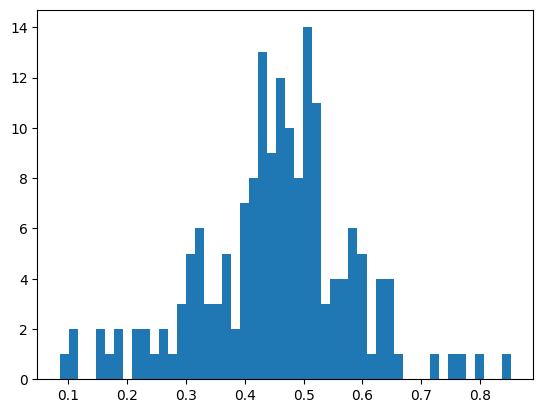

In [101]:
fig, ax = plt.subplots(1, 1)
ax.hist(needs_cholesterol_ridge["Cholesterol"], bins=50)
plt.show()

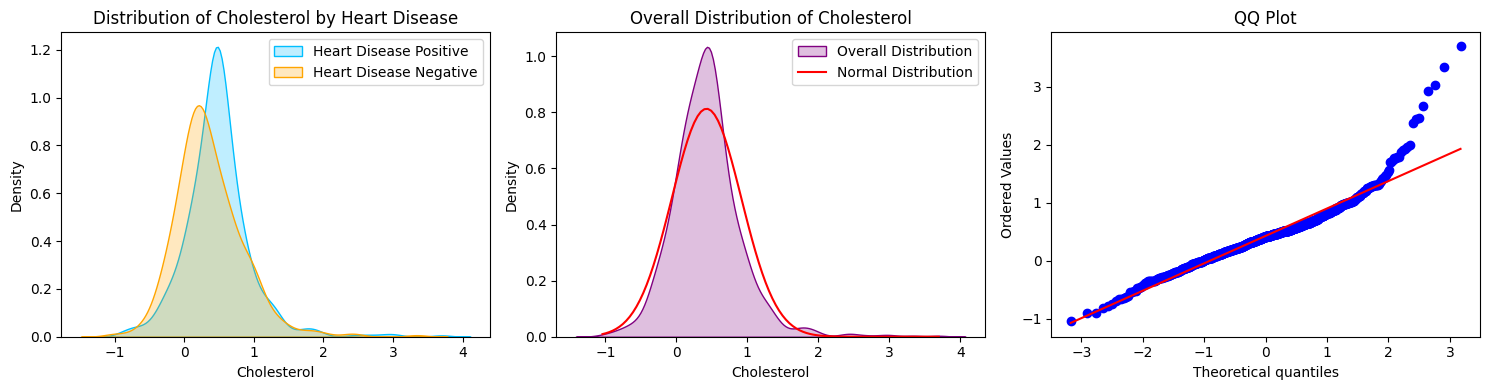

In [102]:
# Filter data for heart disease positive and negative cases
positive_cases = regressed_df1[regressed_df1["HeartDisease"] == 1]["Cholesterol"]
negative_cases = regressed_df1[regressed_df1["HeartDisease"] == 0]["Cholesterol"]

# Create a figure and axes
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))

# Plot KDE for heart disease positive cases
sns.kdeplot(data=positive_cases, fill=True, color="deepskyblue", label="Heart Disease Positive", ax=ax1)

# Plot KDE for heart disease negative cases
sns.kdeplot(data=negative_cases, fill=True, color="orange", label="Heart Disease Negative", ax=ax1)

# Calculate overall distribution
overall_distribution = np.concatenate([positive_cases, negative_cases])

# Plot KDE for overall distribution
sns.kdeplot(data=overall_distribution, fill=True, color="purple", label="Overall Distribution", ax=ax2)

# Generate normal distribution based on overall distribution mean and standard deviation
mu, sigma = overall_distribution.mean(), overall_distribution.std()
x = np.linspace(overall_distribution.min(), overall_distribution.max(), 100)
y = (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mu) / sigma) ** 2)

# Plot superimposed normal distribution
ax2.plot(x, y, color="red", label="Normal Distribution")

# Create QQ plot
res = stats.probplot(overall_distribution, plot=ax3)
ax3.set_title("QQ Plot")

# Set plot labels and titles
ax1.set_xlabel("Cholesterol")
ax1.set_ylabel("Density")
ax1.set_title("Distribution of Cholesterol by Heart Disease")
ax1.legend()

ax2.set_xlabel("Cholesterol")
ax2.set_ylabel("Density")
ax2.set_title("Overall Distribution of Cholesterol")
ax2.legend()

# Adjust spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

combine the original data and the data where cholesterol was added by regression

Try the data with cholesterol estimated by ridge regression on the models

# WARNING TO SELF. THIS WHOLE RIDGE REGRESSION THING SEEMED TO FAIL BY A LOT BECAUSE THESE MODELS ARE BASICALLY GUESSING. I MUSTVE MADE AN ERROR. MAYBE RELATED TO EXTREMLEY LOW R^2
- shuffling the data seems to have a weirdly large effect
- maybe something about normalization and standardization being lost?
- RMSE and MAE are super bad because of reduced range! of course!

In [107]:
display(regressed_df1.isnull().sum())

Age                  0
RestingBP            0
Cholesterol          0
MaxHR                0
Oldpeak              0
HeartDisease         0
Sex_F                0
Sex_M                0
ChestPainType_ASY    0
ChestPainType_ATA    0
ChestPainType_NAP    0
ChestPainType_TA     0
RestingECG_LVH       0
RestingECG_Normal    0
RestingECG_ST        0
ExerciseAngina_N     0
ExerciseAngina_Y     0
ST_Slope_Down        0
ST_Slope_Flat        0
ST_Slope_Up          0
FastingBS_0          0
FastingBS_1          0
dtype: int64

In [108]:
models_df = run_models(regressed_df1.copy(deep=True), continuous_feature_names, categorical_feature_names, models_df, add_experiment, descriptor="ridge", preprocessed=True)
display(models_df.drop("predictions", axis=1).sort_values(by="experiment_name", ascending=False))

6/6 [==============================] - 0s 405us/step


,experiment_name,accuracy,precision,recall,f1,specificity
37,svm_model_ridge,0.690217,0.757282,0.709091,0.732394,0.662162
23,svm_model_mode_imputation,0.918478,0.927928,0.936364,0.932127,0.891892
16,svm_model_median_imputation,0.907609,0.926606,0.918182,0.922374,0.891892
9,svm_model_mean_imputation,0.913043,0.927273,0.927273,0.927273,0.891892
30,svm_model_dl,0.690217,0.757282,0.709091,0.732394,0.662162
2,svm_model1,0.907609,0.911504,0.936364,0.923767,0.864865
36,random_forest_ridge,0.684783,0.750000,0.709091,0.728972,0.648649
22,random_forest_mode_imputation,0.896739,0.917431,0.909091,0.913242,0.878378
15,random_forest_median_imputation,0.891304,0.916667,0.900000,0.908257,0.878378
8,random_forest_mean_imputation,0.885870,0.915888,0.890909,0.903226,0.878378


# figuring out where the models are going wrong

In [ ]:
# starting with logistic regression

misclassified_indices = logistic_regressor1_predictions != y_test
misclassified_samples = x_test[misclassified_indices]
misclassified_true_labels = y_test[misclassified_indices]
misclassified_predicted_labels = logistic_regressor1_predictions[misclassified_indices]



In [ ]:
num_features = len(continuous_feature_names)
num_rows = 2
num_cols = 3

fig, axes = plt.subplots(num_rows, num_cols, figsize=(4 * num_cols, 4 * num_rows))

# Flatten the axes array to iterate over it
axes = axes.flatten()

# Loop through each feature and plot the distributions
for i, feature in enumerate(continuous_feature_names):
    if i < num_features:
        ax = axes[i]

        ax.set_title(f"{feature}")
        sns.kdeplot(df2[feature], fill=True, label="True Distribution", ax=ax)
        sns.kdeplot(misclassified_samples[feature], fill=True, label="Misclassified Distribution", ax=ax)
        ax.legend()

# Remove the empty subplot
if num_features < num_rows * num_cols:
    fig.delaxes(axes[-1])

plt.tight_layout()
plt.show()


# Exporting models

In [ ]:
models_df

In [ ]:
# Create a directory to store the models if it doesn't exist
save_dir = "saved models"
os.makedirs(save_dir, exist_ok=True)

# Save each model
joblib.dump(logistic_regressor1, os.path.join(save_dir, "logistic_regressor1.pkl"))
joblib.dump(gnb_model1, os.path.join(save_dir, "gnb_model1.pkl"))
joblib.dump(random_forest1, os.path.join(save_dir, "random_forest1.pkl"))
joblib.dump(svm_model1, os.path.join(save_dir, "svm_model1.pkl"))